# Prepare

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.optim.lr_scheduler import StepLR
import os
if not os.path.exists('images'):
    os.makedirs('images')
import random
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# Read and cleaning Data

## load data

In [8]:
path = "household_power_consumption.txt"
df = pd.read_csv(path, sep=';', 
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')


C:\Users\20369\AppData\Local\Temp\ipykernel_32608\1450985842.py:2: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(path, sep=';',
C:\Users\20369\AppData\Local\Temp\ipykernel_32608\1450985842.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(path, sep=';',
C:\Users\20369\AppData\Local\Temp\ipykernel_32608\1450985842.py:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(path, sep=';',


## display basic information

In [9]:
print("\n" + "-" * 60)
print("First 10 rows:")
print("-" * 60)
print(df.head(10))

print("\n" + "-" * 60)
print("Last 5 rows:")
print("-" * 60)
print(df.tail())

print("\n" + "-" * 60)
print("Data types:")
print("-" * 60)
print(df.dtypes)

print("\n" + "-" * 60)
print("Data info:")
print("-" * 60)
print(df.info())

print("\n" + "-" * 60)
print("Column names:")
print("-" * 60)
print(df.columns.tolist())

print("\n" + "-" * 60)
print("Basic statistics:")
print("-" * 60)
print(df.describe())

print("\n" + "-" * 60)
print("Memory usage:")
print("-" * 60)
print(df.memory_usage(deep=True))
print(f"\nTotal memory: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# ============================================
# Check data quality
# ============================================
print("\n" + "=" * 60)
print("Data Quality Check")
print("=" * 60)

print("\nMissing values count:")
missing_count = df.isnull().sum()
missing_percent = (df.isnull().sum() / len(df) * 100).round(2)
missing_df = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': missing_count.values,
    'Missing_Percent': missing_percent.values
})
print(missing_df)

print(f"\nTotal missing values: {df.isnull().sum().sum():,}")
print(f"Percentage of total data: {(df.isnull().sum().sum() / (df.shape[0] * df.shape[1]) * 100):.2f}%")

# Check for duplicate rows
duplicates = df.duplicated().sum()
print(f"\nDuplicate rows: {duplicates}")

print("\n" + "=" * 60)
print("Data loading completed!")
print("=" * 60)



------------------------------------------------------------
First 10 rows:
------------------------------------------------------------
                     Global_active_power  Global_reactive_power  Voltage  \
dt                                                                         
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   
2006-12-16 17:29:00                3.520                  0.522   235.02   
2006-12-16 17:30:00                3.702                  0.520   235.09   
2006-12-16 17:31:00                3.700                  0.520   235.22   
2006-12-16 17:32:00                3.668                  0.510   233.99   
2006-12-16 17:33:00       

## clean data
use average to fill the missing data

In [10]:
total = df.isnull().sum().sort_values(ascending=False)
display(total)
for j in range(0,7):        
        df.iloc[:,j] = df.iloc[:,j].fillna(df.iloc[:,j].mean())
df.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

## visulization data

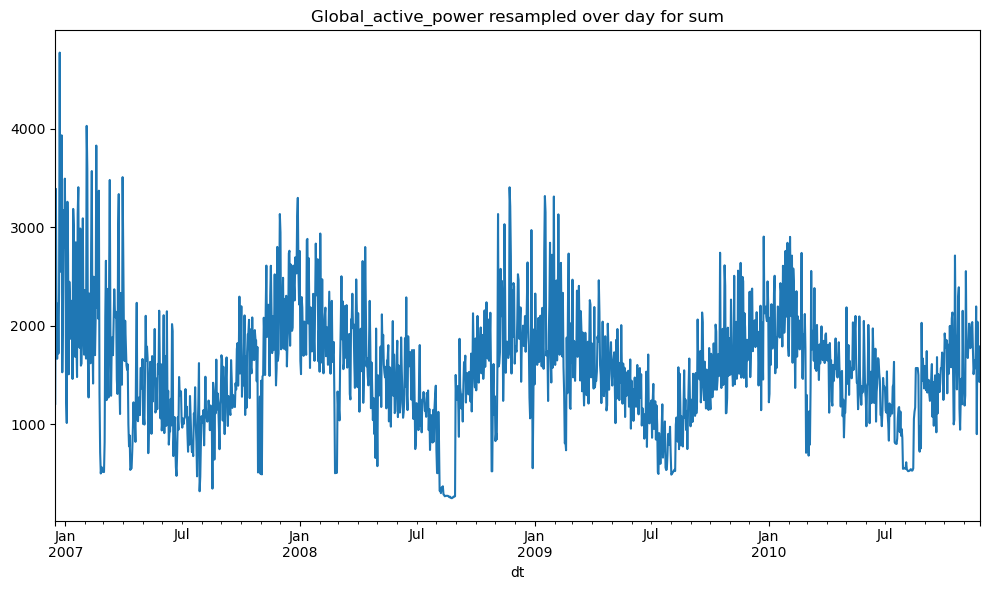

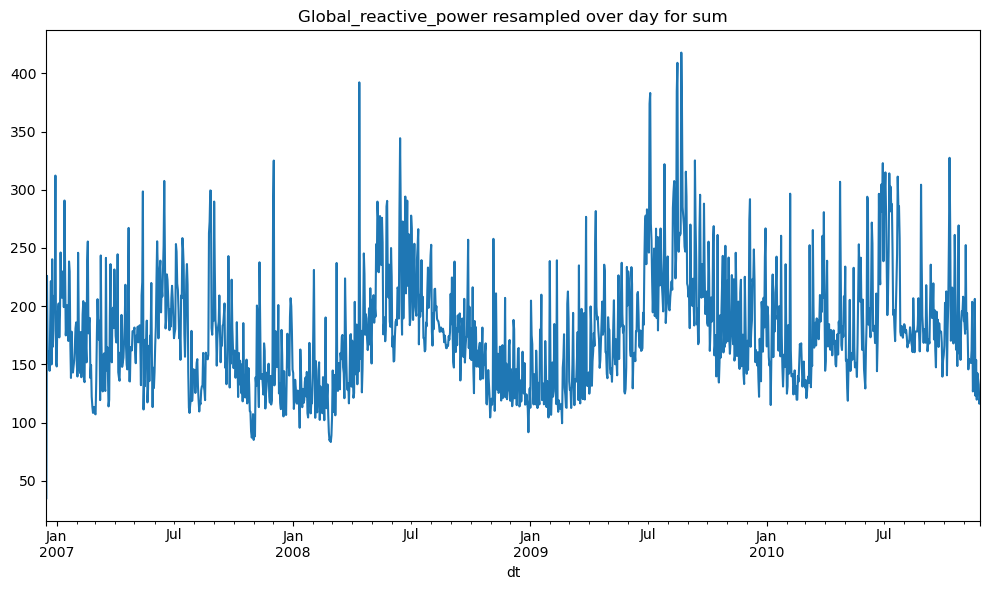

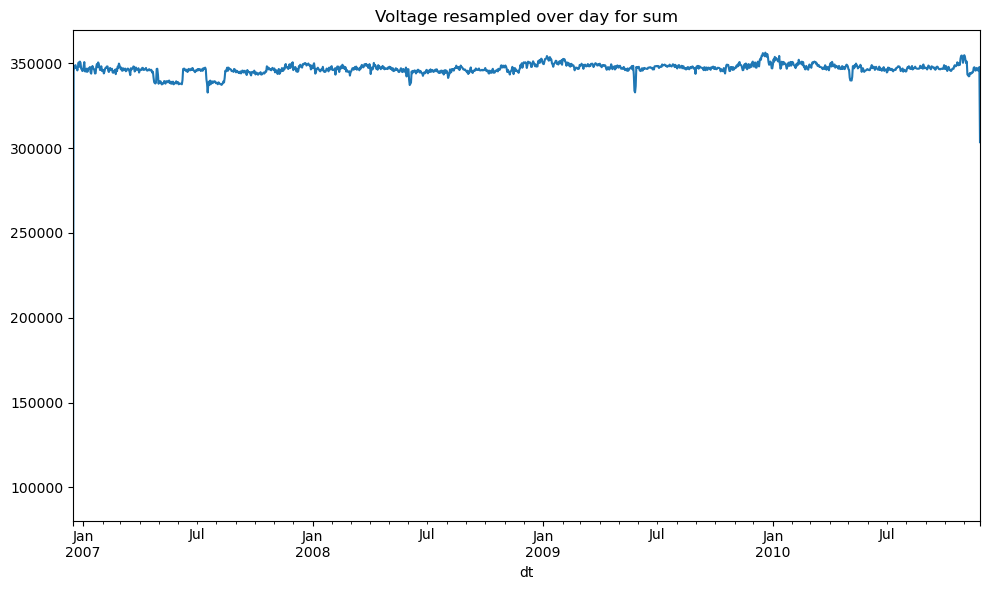

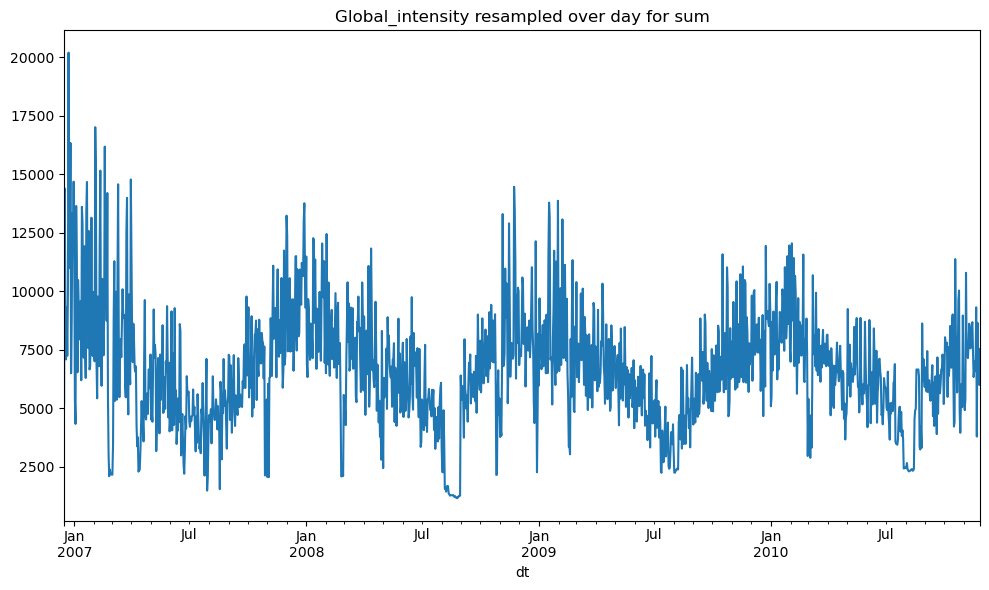

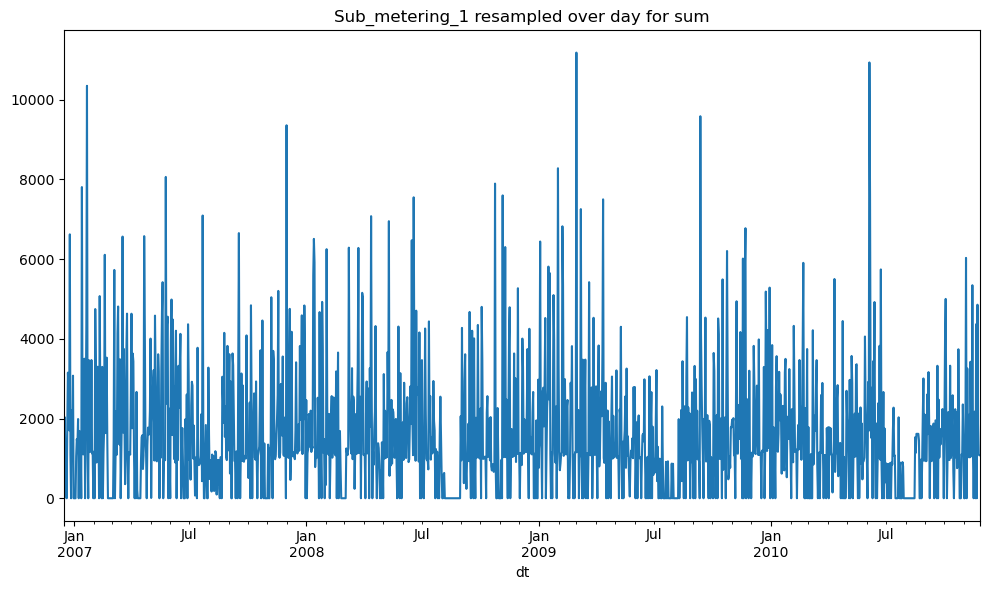

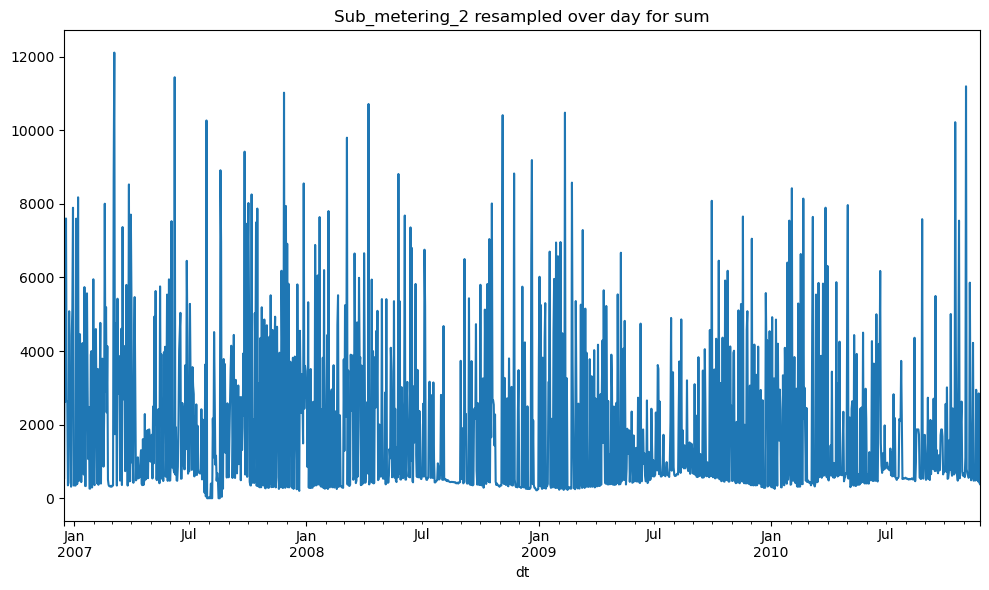

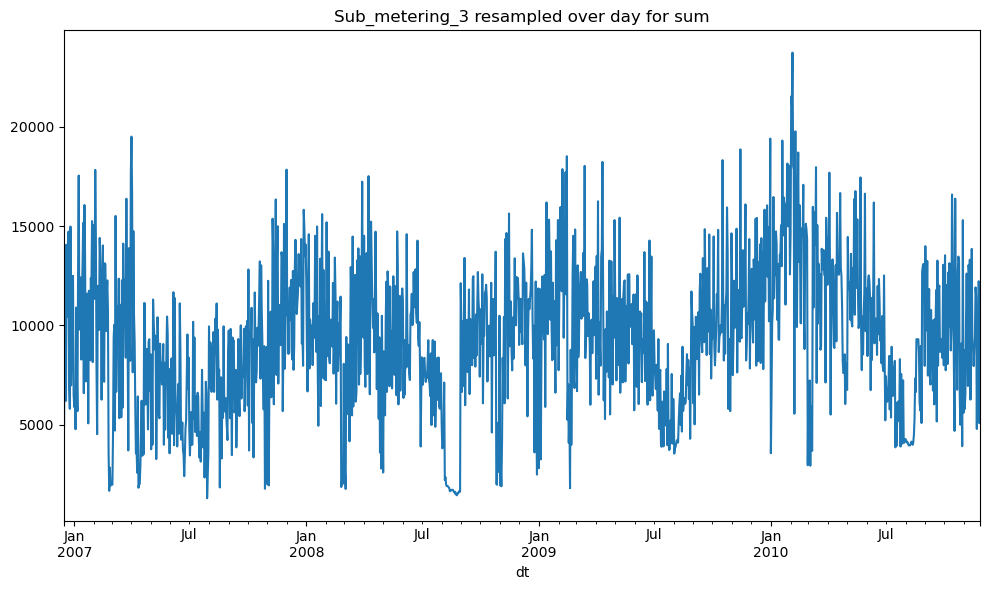

In [11]:
features = ['Global_active_power', 'Global_reactive_power', 'Voltage', 
            'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
for feature in features:
    df_resampled = df[feature].resample('D').sum()
    plt.figure(figsize=(10, 6))
    df_resampled.plot(title=f'{feature} resampled over day for sum')
    plt.tight_layout()
    plt.savefig(f'images/{feature}_resampled.png')
    plt.show()

## check the distribution of different features

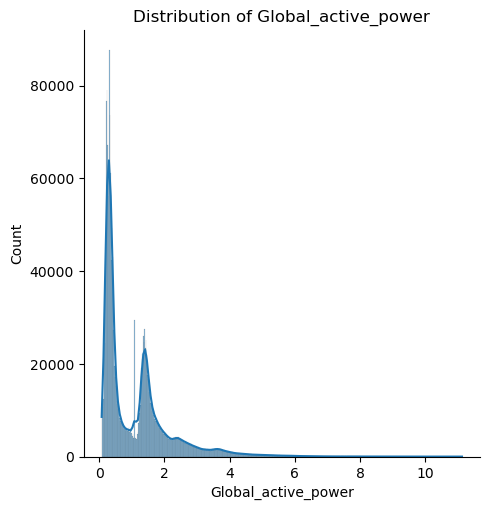

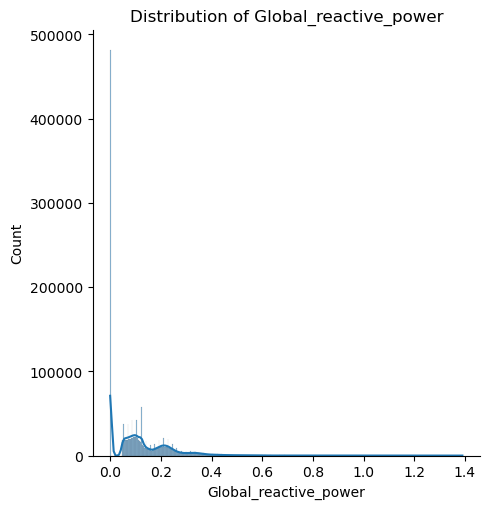

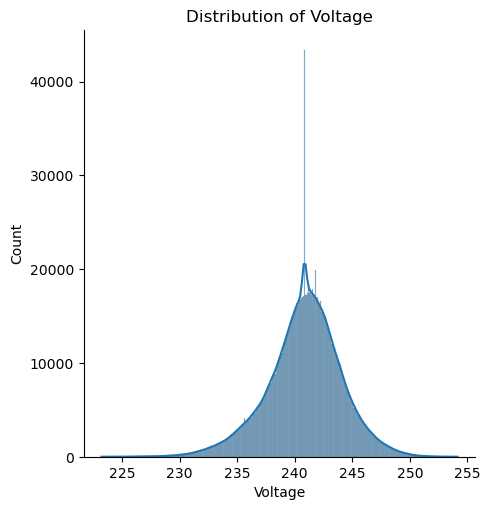

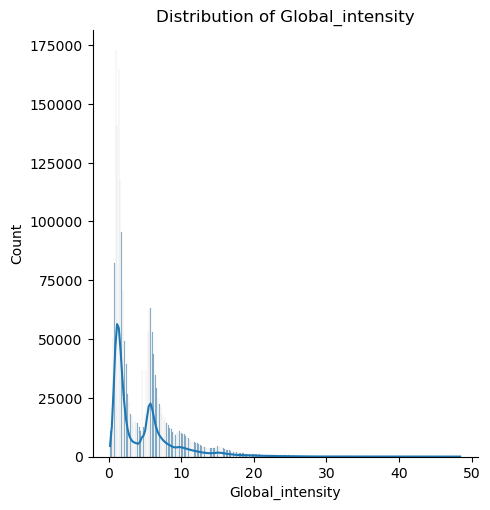

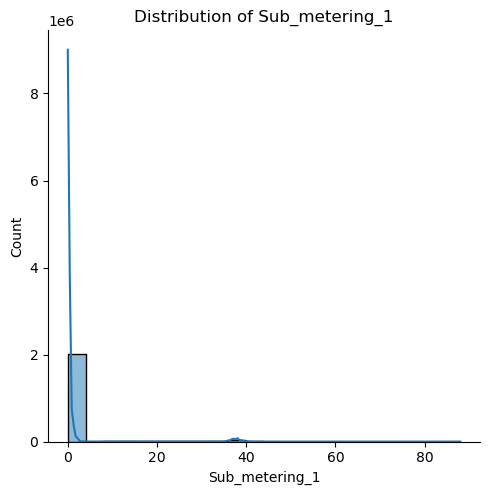

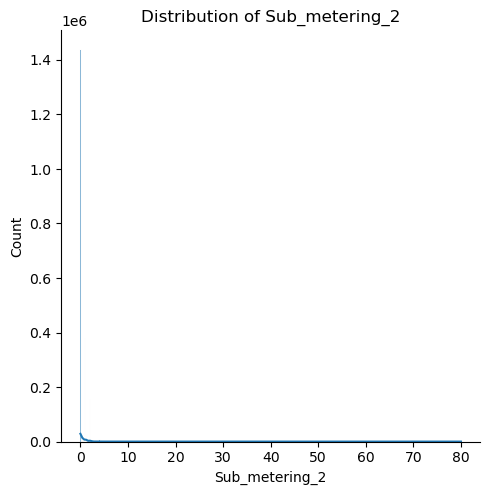

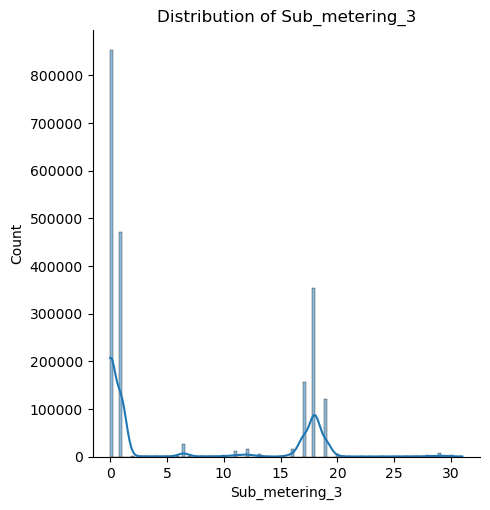

In [5]:
features = ['Global_active_power', 'Global_reactive_power', 'Voltage', 
            'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

for feature in features:
    sns.displot(df[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.savefig(f'images/Distribution_of_{feature}.png')
    plt.show()

## use 3 sigma handle the anomaly data
Winsorizing

Clipped outliers in Global_active_power.
Clipped outliers in Global_reactive_power.
Clipped outliers in Voltage.
Clipped outliers in Global_intensity.
Clipped outliers in Sub_metering_1.
Clipped outliers in Sub_metering_2.
Clipped outliers in Sub_metering_3.


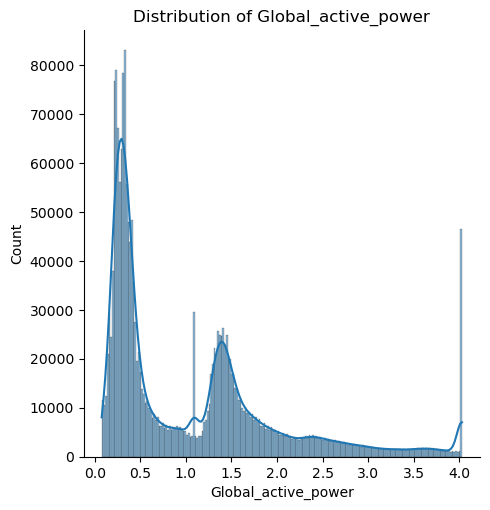

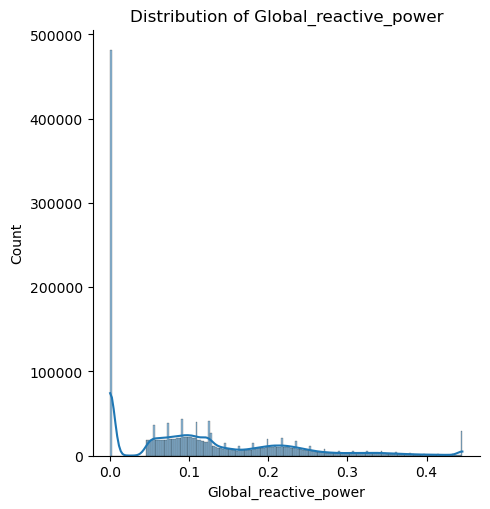

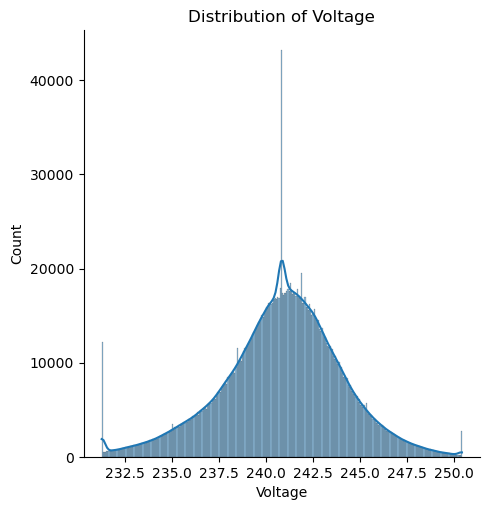

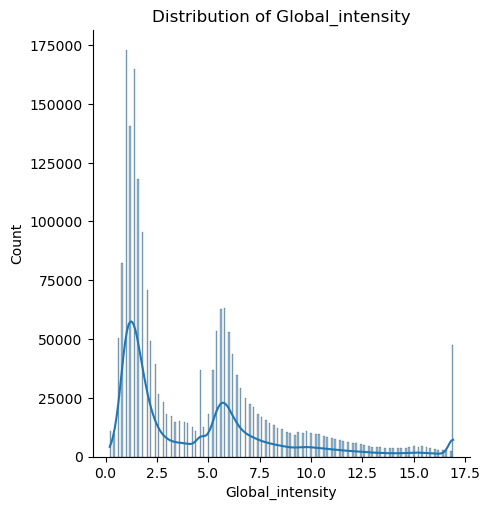

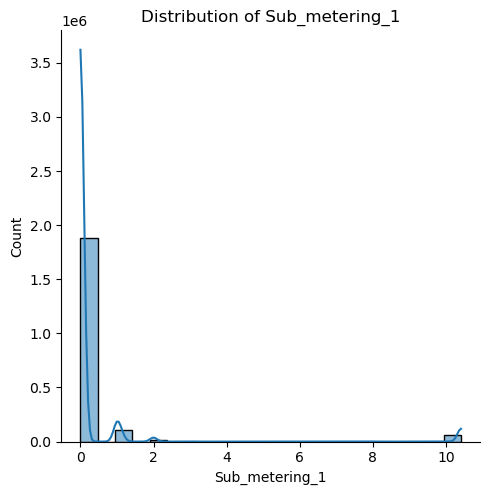

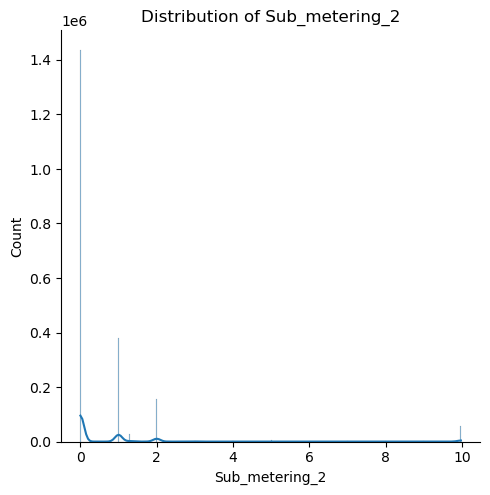

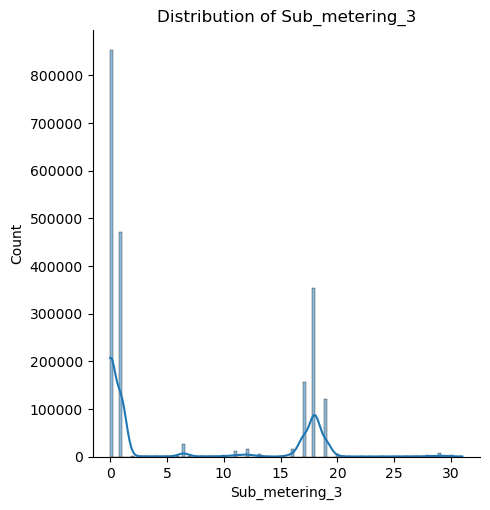

In [7]:
def clip_outliers_3sigma(df, column):
    mean = df[column].mean()
    std = df[column].std()
    lower_bound = mean - 3 * std
    upper_bound = mean + 3 * std
    
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    return df

for feature in features:
    df = clip_outliers_3sigma(df, feature)
    print(f"Clipped outliers in {feature}.")
    
for feature in features:
    sns.displot(df[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.savefig(f'images/After_Clipped_Distribution_of_{feature}.png')
    plt.show()

## correlation between different features

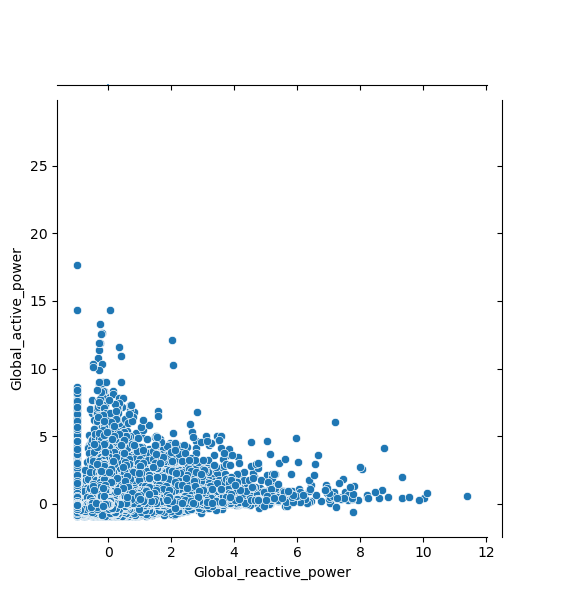

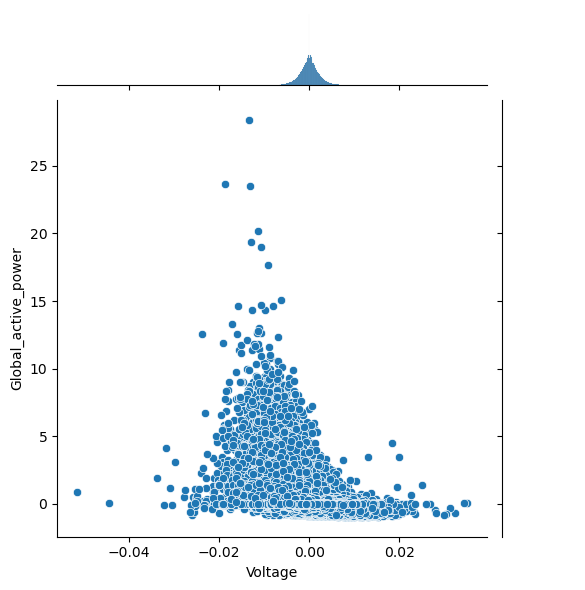

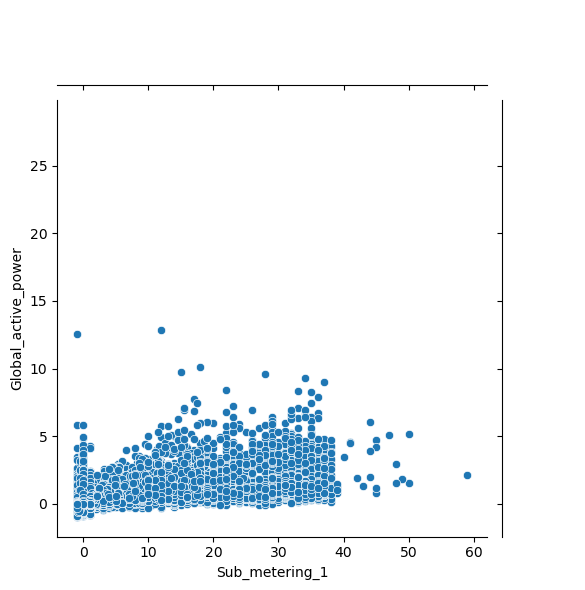

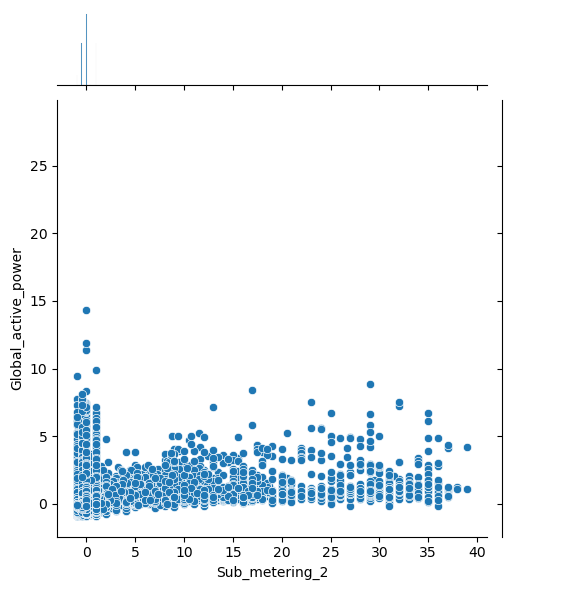

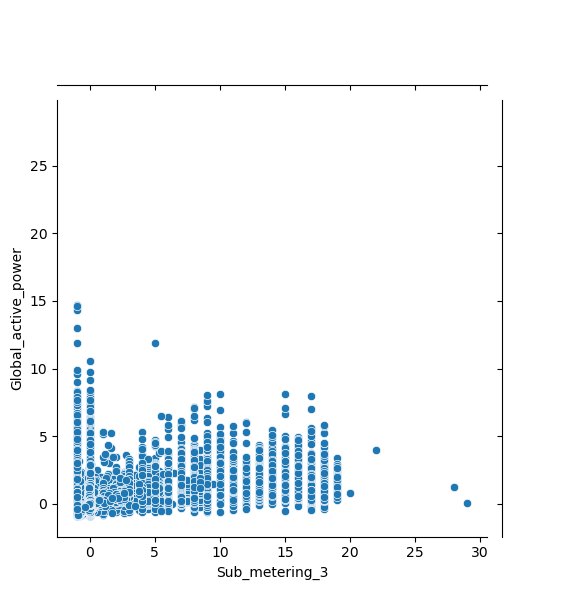

In [13]:
data_returns = df.pct_change()
# for feature in features:
#     sns.jointplot(x=feature, y='Global_active_power', data=data_returns, kind='reg')
#     plt.suptitle(f'Jointplot of {feature} vs Global_active_power')
#     plt.tight_layout()
    
#     plt.savefig(f'images/{feature}_vs_Global_active_power.png')
    
#     plt.show()
features = ['Global_active_power', 'Global_reactive_power', 'Voltage', 
            'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
data_returns = df.pct_change()
sns.jointplot(x='Global_reactive_power', y='Global_active_power', data=data_returns)  
plt.show()

sns.jointplot(x='Voltage', y='Global_active_power', data=data_returns)  
plt.show()

# sns.jointplot(x='Global_intensity', y='Global_active_power', data=data_returns)  
# plt.show()

sns.jointplot(x='Sub_metering_1', y='Global_active_power', data=data_returns)  
plt.show()

sns.jointplot(x='Sub_metering_2', y='Global_active_power', data=data_returns)  
plt.show()

sns.jointplot(x='Sub_metering_3', y='Global_active_power', data=data_returns)  
plt.show()

## Resample over day and week

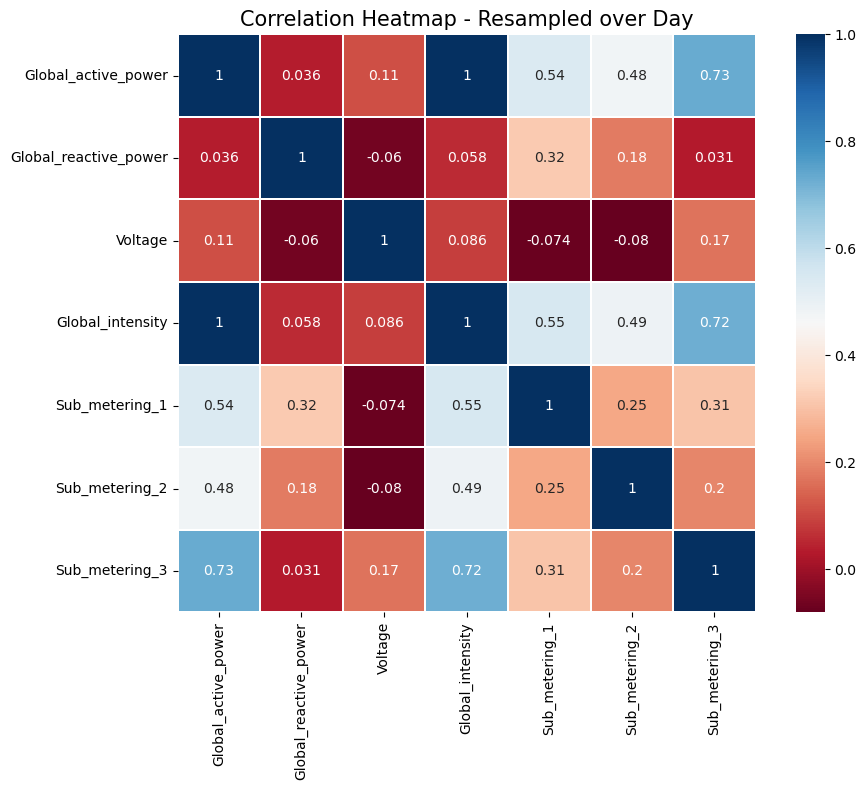

C:\Users\20369\AppData\Local\Temp\ipykernel_32608\1085165775.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  sns.heatmap(df.resample('H').mean().corr(), linewidths=0.1, vmax=1.0,


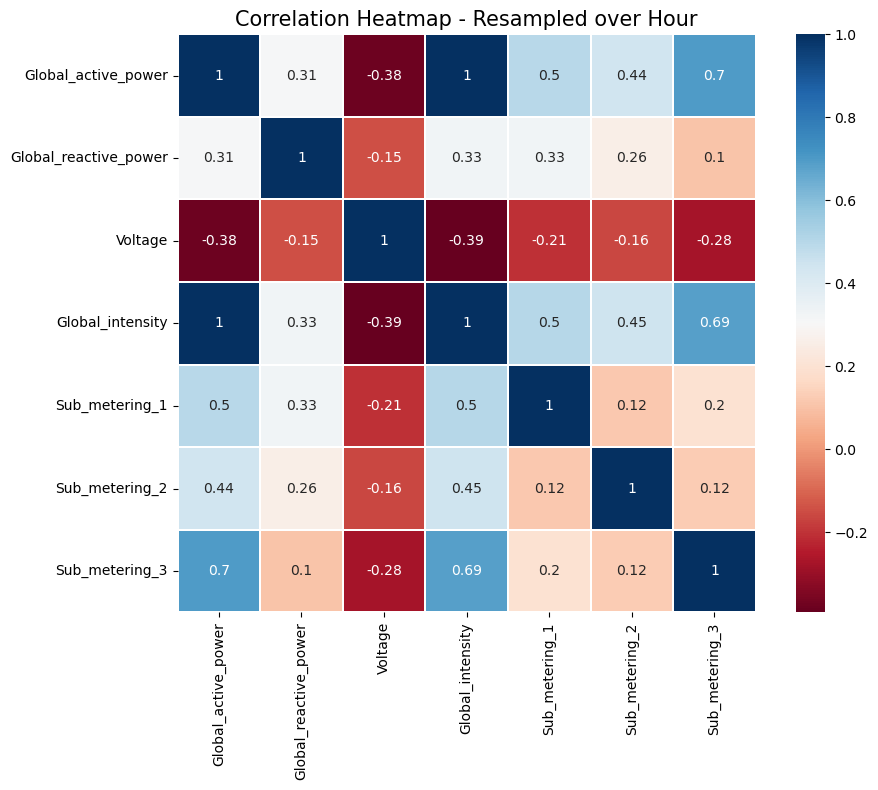

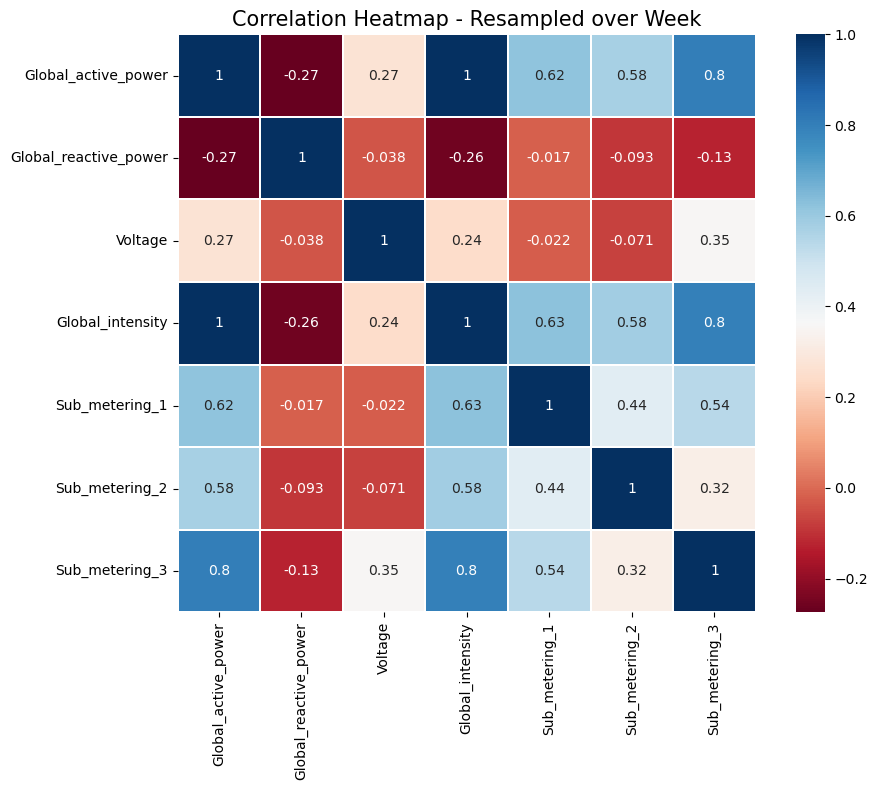

C:\Users\20369\AppData\Local\Temp\ipykernel_32608\1085165775.py:27: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  sns.heatmap(df.resample('Y').mean().corr(), linewidths=0.1, vmax=1.0,


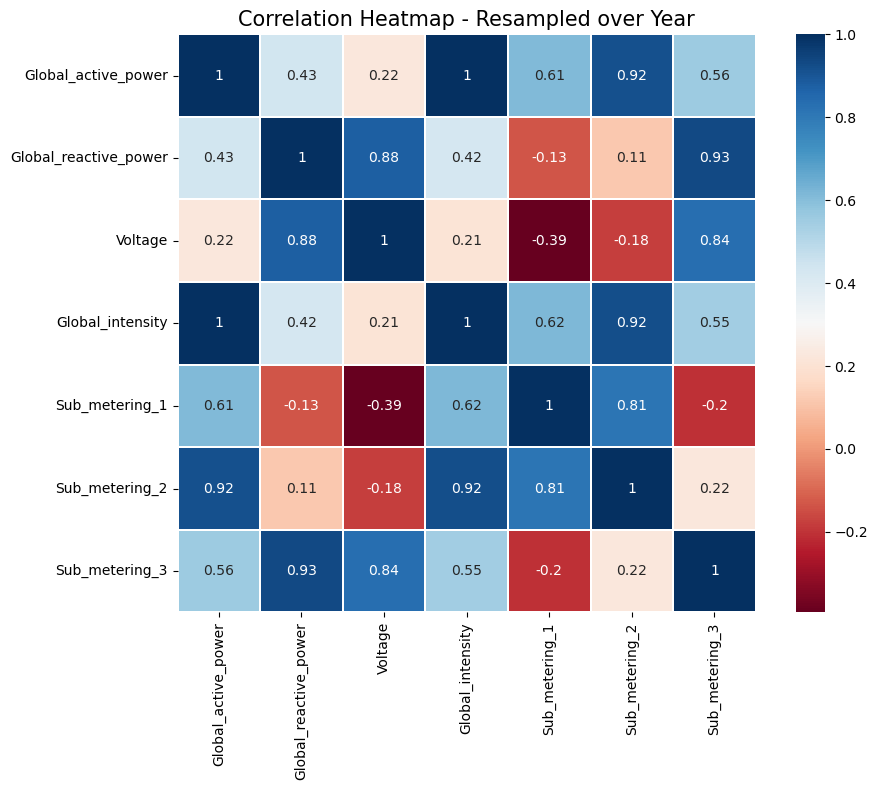

In [14]:
plt.figure(figsize=(10, 8))
plt.title('Correlation Heatmap - Resampled over Day', size=15)
sns.heatmap(df.resample('D').mean().corr(), linewidths=0.1, vmax=1.0, 
            square=True, cmap=plt.cm.RdBu, linecolor='white', annot=True)
plt.tight_layout()
plt.savefig('images/correlation_heatmap_resampled_over_day.png')
plt.show()

plt.figure(figsize=(10, 8))
plt.title('Correlation Heatmap - Resampled over Hour', size=15)
sns.heatmap(df.resample('H').mean().corr(), linewidths=0.1, vmax=1.0, 
            square=True, cmap=plt.cm.RdBu, linecolor='white', annot=True)
plt.tight_layout()
plt.savefig('images/correlation_heatmap_resampled_over_hour.png')
plt.show()

plt.figure(figsize=(10, 8))
plt.title('Correlation Heatmap - Resampled over Week', size=15)
sns.heatmap(df.resample('W').mean().corr(), linewidths=0.1, vmax=1.0, 
            square=True, cmap=plt.cm.RdBu, linecolor='white', annot=True)
plt.tight_layout()
plt.savefig('images/correlation_heatmap_resampled_over_week.png')
plt.show()

plt.figure(figsize=(10, 8))
plt.title('Correlation Heatmap - Resampled over Year', size=15)
sns.heatmap(df.resample('Y').mean().corr(), linewidths=0.1, vmax=1.0, 
            square=True, cmap=plt.cm.RdBu, linecolor='white', annot=True)
plt.tight_layout()
plt.savefig('images/correlation_heatmap_resampled_over_year.png')
plt.show()

In [15]:
def convert_to_time_series(dataset, input_steps=1, output_steps=1, remove_na=True):
    num_features = 1 if isinstance(dataset, list) else dataset.shape[1]
    data_frame = pd.DataFrame(dataset)
    features, column_names = list(), list()
    
    for lag in range(input_steps, 0, -1):
        features.append(data_frame.shift(lag))
        column_names += [('feature%d(t-%d)' % (feat_idx+1, lag)) for feat_idx in range(num_features)]
    
    for lead in range(0, output_steps):
        features.append(data_frame.shift(-lead))
        if lead == 0:
            column_names += [('feature%d(t)' % (feat_idx+1)) for feat_idx in range(num_features)]
        else:
            column_names += [('feature%d(t+%d)' % (feat_idx+1, lead)) for feat_idx in range(num_features)]
    
    combined_data = pd.concat(features, axis=1)
    combined_data.columns = column_names
    
    if remove_na:
        combined_data.dropna(inplace=True)
        
    return combined_data


## Resample use hour

In [16]:
df_resample = df.resample('h').mean() 
df_resample.shape
print(df_resample.head())

                     Global_active_power  Global_reactive_power     Voltage  \
dt                                                                            
2006-12-16 17:00:00             4.222889               0.229000  234.643889   
2006-12-16 18:00:00             3.632200               0.080033  234.580167   
2006-12-16 19:00:00             3.400233               0.085233  233.232500   
2006-12-16 20:00:00             3.268567               0.075100  234.071500   
2006-12-16 21:00:00             3.056467               0.076667  237.158667   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
dt                                                                      
2006-12-16 17:00:00         18.100000             0.0        0.527778   
2006-12-16 18:00:00         15.600000             0.0        6.716667   
2006-12-16 19:00:00         14.503333             0.0        1.433333   
2006-12-16 20:00:00         13.916667             0.0        0.000000   
2006-12-

## normalization

In [17]:
raw_data = df_resample.values
normalizer = MinMaxScaler(feature_range=(0, 1))
normalized_data = normalizer.fit_transform(raw_data)
time_series_data = convert_to_time_series(normalized_data, 1, 1)
print(time_series_data.head())
time_series_data.drop(time_series_data.columns[[8,9,10,11,12,13]], axis=1, inplace=True)
print(time_series_data.head())

   feature1(t-1)  feature2(t-1)  feature3(t-1)  feature4(t-1)  feature5(t-1)  \
1       0.636816       0.295738       0.337945       0.631157            0.0   
2       0.545045       0.103358       0.335501       0.541487            0.0   
3       0.509006       0.110073       0.283802       0.502152            0.0   
4       0.488550       0.096987       0.315987       0.481110            0.0   
5       0.455597       0.099010       0.434417       0.449904            0.0   

   feature6(t-1)  feature7(t-1)  feature1(t)  feature2(t)  feature3(t)  \
1       0.011366       0.782418     0.545045     0.103358     0.335501   
2       0.144652       0.782676     0.509006     0.110073     0.283802   
3       0.030869       0.774169     0.488550     0.096987     0.315987   
4       0.000000       0.778809     0.455597     0.099010     0.434417   
5       0.008973       0.798917     0.322555     0.072536     0.495847   

   feature4(t)  feature5(t)  feature6(t)  feature7(t)  
1     0.541487    

## data split and save
70 train
15 validation
15 test

In [25]:
import random
import numpy as np
import torch

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

processed_data = time_series_data.values

total_samples = len(processed_data)
train_size = int(total_samples * 0.7)
validation_size = int(total_samples * 0.15)
test_size = total_samples - train_size - validation_size

training_set = processed_data[:train_size, :]
validation_set = processed_data[train_size:train_size + validation_size, :]
testing_set = processed_data[train_size + validation_size:, :]

train_features, train_labels = training_set[:, :-1], training_set[:, -1]
val_features, val_labels = validation_set[:, :-1], validation_set[:, -1]
test_features, test_labels = testing_set[:, :-1], testing_set[:, -1]

train_features = train_features.reshape((train_features.shape[0], 1, train_features.shape[1]))
val_features = val_features.reshape((val_features.shape[0], 1, val_features.shape[1]))
test_features = test_features.reshape((test_features.shape[0], 1, test_features.shape[1]))

train_features_tensor = torch.tensor(train_features, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float32).view(-1, 1)
val_features_tensor = torch.tensor(val_features, dtype=torch.float32)
val_labels_tensor = torch.tensor(val_labels, dtype=torch.float32).view(-1, 1)
test_features_tensor = torch.tensor(test_features, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float32).view(-1, 1)

train_data = TensorDataset(train_features_tensor, train_labels_tensor)
train_data_loader = DataLoader(train_data, batch_size=70, shuffle=False)
val_data = TensorDataset(val_features_tensor, val_labels_tensor)
val_data_loader = DataLoader(val_data, batch_size=70, shuffle=False)

# CNN

## define CNN model

Epoch 1/50, Train Loss: 0.0145, Val Loss: 0.0101, LR: 0.001000
Epoch 2/50, Train Loss: 0.0104, Val Loss: 0.0096, LR: 0.001000
Epoch 3/50, Train Loss: 0.0098, Val Loss: 0.0095, LR: 0.001000
Epoch 4/50, Train Loss: 0.0097, Val Loss: 0.0096, LR: 0.001000
Epoch 5/50, Train Loss: 0.0096, Val Loss: 0.0096, LR: 0.001000
Epoch 6/50, Train Loss: 0.0095, Val Loss: 0.0095, LR: 0.001000
Epoch 7/50, Train Loss: 0.0096, Val Loss: 0.0096, LR: 0.001000
Epoch 8/50, Train Loss: 0.0095, Val Loss: 0.0095, LR: 0.001000
Epoch 9/50, Train Loss: 0.0095, Val Loss: 0.0096, LR: 0.001000
Epoch 10/50, Train Loss: 0.0094, Val Loss: 0.0097, LR: 0.001000
Epoch 11/50, Train Loss: 0.0094, Val Loss: 0.0096, LR: 0.001000
Epoch 12/50, Train Loss: 0.0093, Val Loss: 0.0096, LR: 0.001000
Epoch 13/50, Train Loss: 0.0093, Val Loss: 0.0096, LR: 0.001000
Epoch 14/50, Train Loss: 0.0093, Val Loss: 0.0096, LR: 0.001000
Epoch 15/50, Train Loss: 0.0094, Val Loss: 0.0097, LR: 0.001000
Epoch 16/50, Train Loss: 0.0093, Val Loss: 0.0097

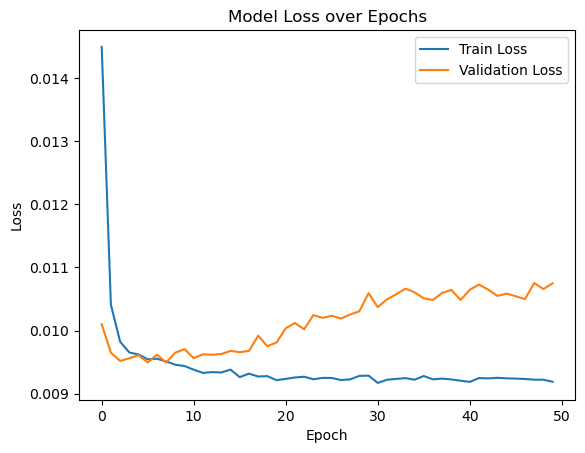

In [63]:

validation_history = []

from TimeSeriesCNN import TimeSeriesCNN

cnn_model = TimeSeriesCNN(feature_channels=1, sequence_length=train_features_tensor.shape[2], prediction_dim=1)
loss_function = nn.MSELoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.5) 

early_stop_patience = 10
best_validation_loss = float('inf')
patience_counter = 0

num_epochs = 50
training_history = []
validation_history = []


for epoch_idx in range(num_epochs):
    cnn_model.train()
    epoch_train_loss = 0
    for batch_features, batch_labels in train_data_loader:
        optimizer.zero_grad()
        predictions = cnn_model(batch_features)
        batch_loss = loss_function(predictions, batch_labels)
        batch_loss.backward()
        optimizer.step()
        epoch_train_loss += batch_loss.item()
    epoch_train_loss /= len(train_data_loader)
    training_history.append(epoch_train_loss)

    cnn_model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for batch_features, batch_labels in val_data_loader:
            predictions = cnn_model(batch_features)
            batch_loss = loss_function(predictions, batch_labels)
            epoch_val_loss += batch_loss.item()
        epoch_val_loss /= len(val_data_loader)
        validation_history.append(epoch_val_loss)

    print(f"Epoch {epoch_idx+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, LR: {lr_scheduler.get_last_lr()[0]:.6f}")
    
    # lr_scheduler.step()
    
    # if epoch_val_loss < best_validation_loss:
    #     best_validation_loss = epoch_val_loss
    #     patience_counter = 0
    # else:
    #     patience_counter += 1
    #     if patience_counter >= early_stop_patience:
    #         print(f"Early stopping triggered after {epoch_idx+1} epochs.")
    #         break

plt.plot(training_history, label='Train Loss')
plt.plot(validation_history, label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


## evaluate

Test Loss: 0.0066
Test MSE: 0.2717
Test MAE: 0.3976
Test RMSE: 0.521


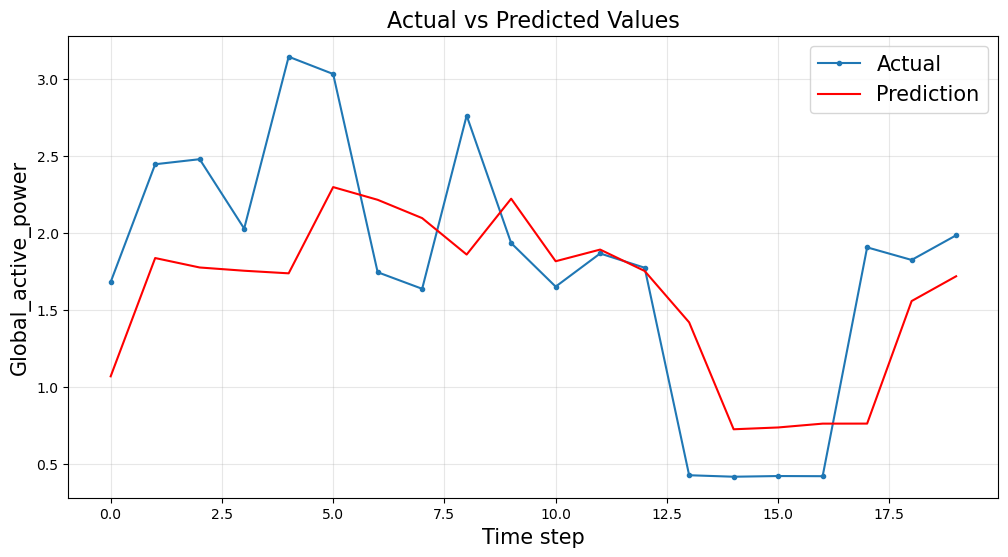

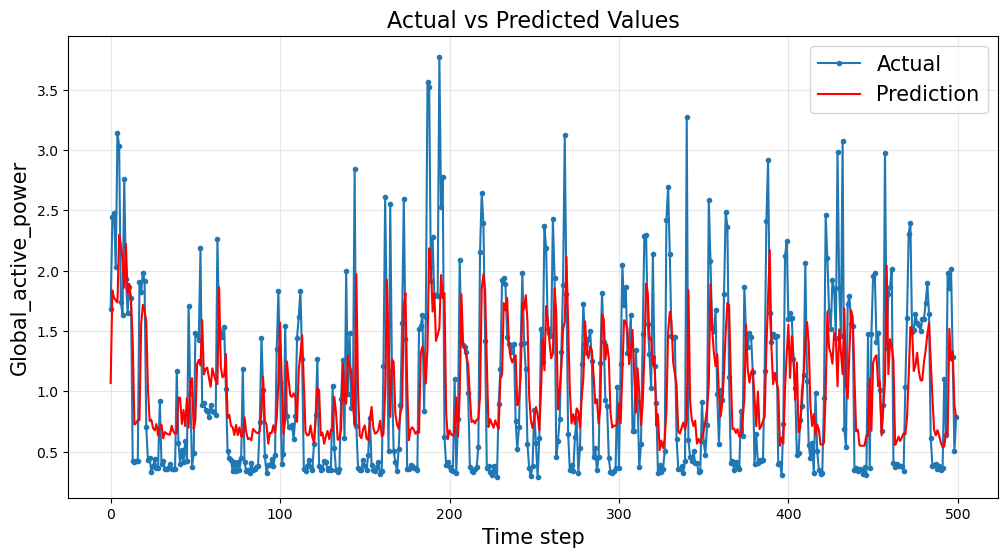

In [44]:
cnn_model.eval()
with torch.no_grad():
    test_predictions = cnn_model(test_features_tensor)
    test_error = loss_function(test_predictions, test_labels_tensor).item()
    print(f"Test Loss: {test_error:.4f}")
    
    predicted_values = test_predictions.numpy()

denorm_predictions = np.concatenate((predicted_values, test_features_tensor.numpy()[:, 0, -6:]), axis=1)
denorm_predictions = normalizer.inverse_transform(denorm_predictions)
final_predictions = denorm_predictions[:, 0]

denorm_actual = np.concatenate((test_labels_tensor.numpy(), test_features_tensor.numpy()[:, 0, -6:]), axis=1)
denorm_actual = normalizer.inverse_transform(denorm_actual)
final_actual = denorm_actual[:, 0]

error_mse = mean_squared_error(final_actual, final_predictions)
error_mae = mean_absolute_error(final_actual, final_predictions)
error_rmse = np.sqrt(error_mse)

print(f'Test MSE: {error_mse:.4f}')
print(f'Test MAE: {error_mae:.4f}')
print(f'Test RMSE: {error_rmse:.3f}')

display_count = 20
time_indices = list(range(display_count))

plt.figure(figsize=(12, 6))
plt.plot(time_indices, final_actual[:display_count], marker='.', label="Actual")
plt.plot(time_indices, final_predictions[:display_count], 'r', label="Prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.title('Actual vs Predicted Values', size=16)
plt.legend(fontsize=15)
plt.grid(True, alpha=0.3)
plt.show()

display_count = 500
time_indices = list(range(display_count))

plt.figure(figsize=(12, 6))
plt.plot(time_indices, final_actual[:display_count], marker='.', label="Actual")
plt.plot(time_indices, final_predictions[:display_count], 'r', label="Prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.title('Actual vs Predicted Values', size=16)
plt.legend(fontsize=15)
plt.grid(True, alpha=0.3)
plt.show()




# LSTM

## define model

Epoch 1/200, Train Loss: 0.0313, Val Loss: 0.0313, LR: 0.001000
Epoch 2/200, Train Loss: 0.0217, Val Loss: 0.0275, LR: 0.001000
Epoch 3/200, Train Loss: 0.0204, Val Loss: 0.0265, LR: 0.001000
Epoch 4/200, Train Loss: 0.0201, Val Loss: 0.0261, LR: 0.001000
Epoch 5/200, Train Loss: 0.0201, Val Loss: 0.0263, LR: 0.001000
Epoch 6/200, Train Loss: 0.0200, Val Loss: 0.0262, LR: 0.001000
Epoch 7/200, Train Loss: 0.0200, Val Loss: 0.0262, LR: 0.001000
Epoch 8/200, Train Loss: 0.0199, Val Loss: 0.0260, LR: 0.001000
Epoch 9/200, Train Loss: 0.0199, Val Loss: 0.0262, LR: 0.001000
Epoch 10/200, Train Loss: 0.0199, Val Loss: 0.0261, LR: 0.001000
Epoch 11/200, Train Loss: 0.0198, Val Loss: 0.0259, LR: 0.000500
Epoch 12/200, Train Loss: 0.0198, Val Loss: 0.0257, LR: 0.000500
Epoch 13/200, Train Loss: 0.0198, Val Loss: 0.0255, LR: 0.000500
Epoch 14/200, Train Loss: 0.0197, Val Loss: 0.0254, LR: 0.000500
Epoch 15/200, Train Loss: 0.0198, Val Loss: 0.0253, LR: 0.000500
Epoch 16/200, Train Loss: 0.0197, 

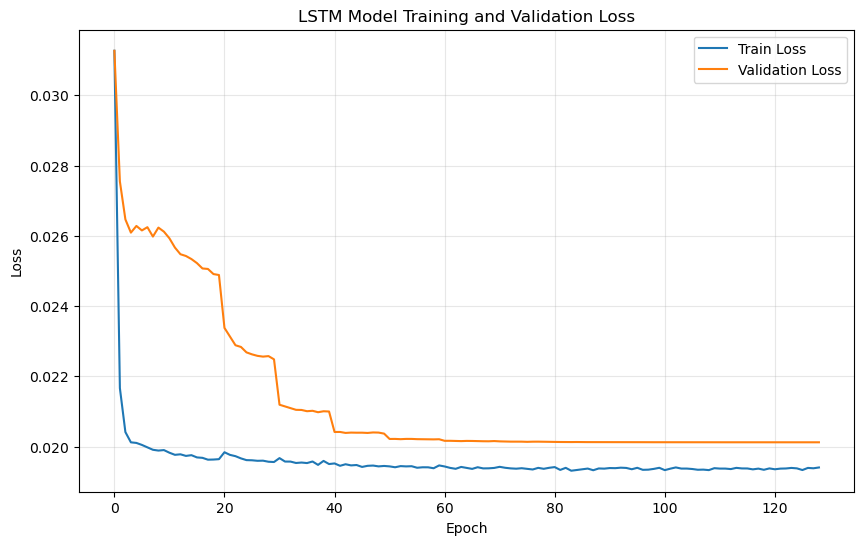

In [ ]:
from TimeSeriesLSTM import TimeSeriesLSTM

lstm_model = TimeSeriesLSTM(
    feature_dim=train_features_tensor.shape[2], 
    hidden_dim=100, 
    output_dim=1
)

loss_function = nn.MSELoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

early_stop_patience = 10
lowest_val_loss = float('inf')
stagnation_counter = 0

max_epochs = 50
training_history = []
validation_history = []

for epoch_idx in range(max_epochs):
    lstm_model.train()
    epoch_train_loss = 0
    for batch_features, batch_labels in train_data_loader:
        optimizer.zero_grad()
        predictions = lstm_model(batch_features)
        batch_loss = loss_function(predictions, batch_labels)
        
        batch_loss.backward()
        optimizer.step()
        epoch_train_loss += batch_loss.item()
    
    epoch_train_loss /= len(train_data_loader)
    training_history.append(epoch_train_loss)

    lstm_model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for batch_features, batch_labels in val_data_loader:
            predictions = lstm_model(batch_features)
            batch_loss = loss_function(predictions, batch_labels)
            epoch_val_loss += batch_loss.item()
        
        epoch_val_loss /= len(val_data_loader)
        validation_history.append(epoch_val_loss)

    current_lr = lr_scheduler.get_last_lr()[0]
    print(f"Epoch {epoch_idx+1}/{max_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, LR: {current_lr:.6f}")
    
    lr_scheduler.step()

    if epoch_val_loss < lowest_val_loss:
        lowest_val_loss = epoch_val_loss
        stagnation_counter = 0
    else:
        stagnation_counter += 1
        if stagnation_counter >= early_stop_patience:
            print(f"Early stopping triggered after {epoch_idx+1} epochs.")
            break

plt.figure(figsize=(10, 6))
plt.plot(training_history, label='Train Loss')
plt.plot(validation_history, label='Validation Loss')
plt.title('LSTM Model Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.show()




## evaluate

Test Loss: 0.0151
Test MSE: 0.2595
Test MAE: 0.3750
Test RMSE: 0.509


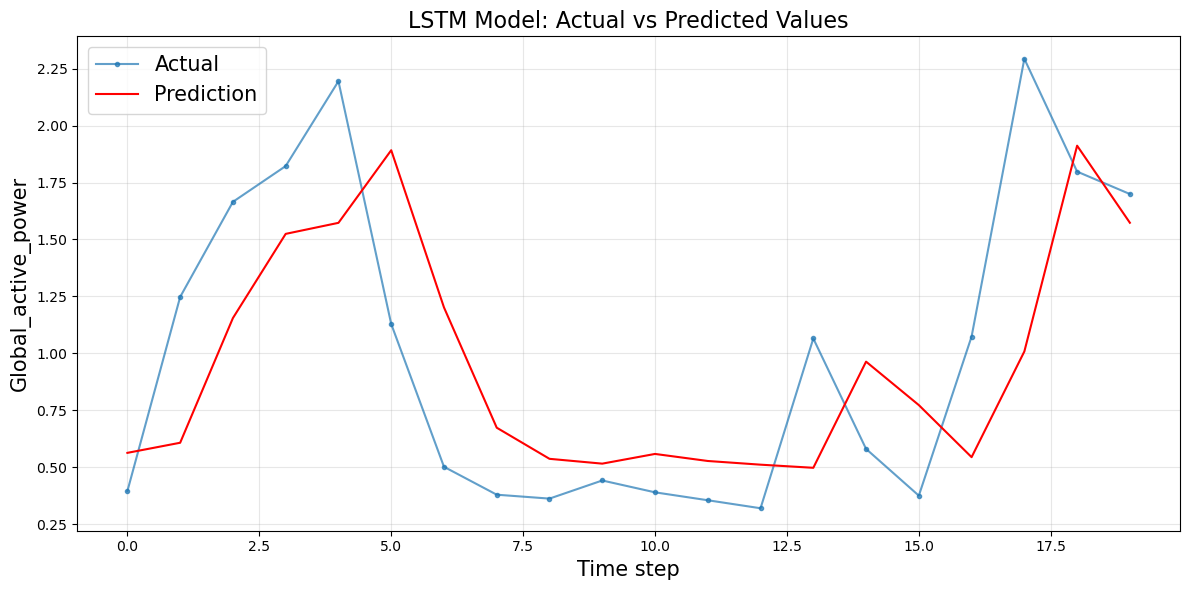

In [92]:
lstm_model.eval()
with torch.no_grad():
    test_predictions = lstm_model(test_features_tensor)
    test_error = loss_function(test_predictions, test_labels_tensor).item()
    print(f"Test Loss: {test_error:.4f}")
    
    predicted_values = test_predictions.numpy()

denorm_predictions = np.concatenate((
    predicted_values,
    test_features_tensor.numpy()[:, 0, -6:]
), axis=1)
denorm_predictions = normalizer.inverse_transform(denorm_predictions)
final_predictions = denorm_predictions[:, 0]

denorm_actual = np.concatenate((
    test_labels_tensor.numpy(),
    test_features_tensor.numpy()[:, 0, -6:]
), axis=1)
denorm_actual = normalizer.inverse_transform(denorm_actual)
final_actual = denorm_actual[:, 0]

error_mse = mean_squared_error(final_actual, final_predictions)
error_mae = mean_absolute_error(final_actual, final_predictions)
error_rmse = np.sqrt(error_mse)

print(f'Test MSE: {error_mse:.4f}')
print(f'Test MAE: {error_mae:.4f}')
print(f'Test RMSE: {error_rmse:.3f}')

display_count = 20
time_steps = list(range(display_count))

plt.figure(figsize=(12, 6))
plt.plot(time_steps, final_actual[:display_count], marker='.', label="Actual", alpha=0.7)
plt.plot(time_steps, final_predictions[:display_count], 'r', label="Prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.title('LSTM Model: Actual vs Predicted Values', size=16)
plt.legend(fontsize=15)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# Transform

## define transform model

e:\anaconda3\envs\ml\lib\site-packages\torch\nn\modules\transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/200, Train Loss: 0.1037, Val Loss: 0.0225, LR: 0.001000
Epoch 2/200, Train Loss: 0.0230, Val Loss: 0.0220, LR: 0.001000
Epoch 3/200, Train Loss: 0.0219, Val Loss: 0.0216, LR: 0.001000
Epoch 4/200, Train Loss: 0.0213, Val Loss: 0.0212, LR: 0.001000
Epoch 5/200, Train Loss: 0.0213, Val Loss: 0.0213, LR: 0.001000
Epoch 6/200, Train Loss: 0.0210, Val Loss: 0.0210, LR: 0.001000
Epoch 7/200, Train Loss: 0.0208, Val Loss: 0.0209, LR: 0.001000
Epoch 8/200, Train Loss: 0.0205, Val Loss: 0.0212, LR: 0.001000
Epoch 9/200, Train Loss: 0.0204, Val Loss: 0.0205, LR: 0.001000
Epoch 10/200, Train Loss: 0.0203, Val Loss: 0.0210, LR: 0.001000
Epoch 11/200, Train Loss: 0.0200, Val Loss: 0.0219, LR: 0.000500
Epoch 12/200, Train Loss: 0.0200, Val Loss: 0.0223, LR: 0.000500
Epoch 13/200, Train Loss: 0.0199, Val Loss: 0.0215, LR: 0.000500
Epoch 14/200, Train Loss: 0.0198, Val Loss: 0.0221, LR: 0.000500
Epoch 15/200, Train Loss: 0.0198, Val Loss: 0.0218, LR: 0.000500
Epoch 16/200, Train Loss: 0.0196, 

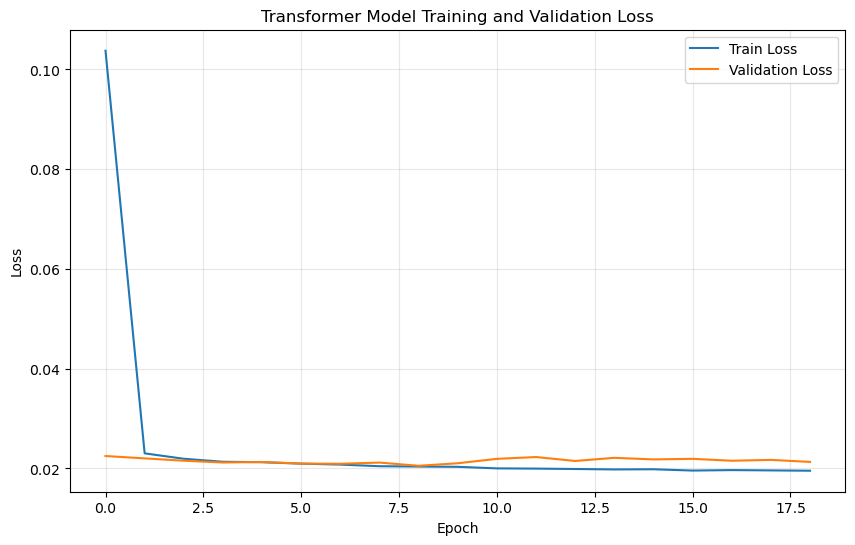

In [ ]:
from TimeSeriesTransformer import TimeSeriesTransformer

transformer_model = TimeSeriesTransformer(
    feature_dim=train_features_tensor.shape[2],  
    hidden_dim=128,                              
    output_dim=1,                                
    attention_heads=8,                           
    encoder_layers=2,                            
    dropout_rate=0.2                             
)

loss_function = nn.MSELoss()
optimizer = optim.Adam(transformer_model.parameters(), lr=0.001)

lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

early_stop_patience = 10
lowest_val_loss = float('inf')
stagnation_counter = 0

max_epochs = 200
training_history = []
validation_history = []

for epoch_idx in range(max_epochs):
    transformer_model.train()
    epoch_train_loss = 0
    
    for batch_features, batch_labels in train_data_loader:
        optimizer.zero_grad()
        predictions = transformer_model(batch_features)
        batch_loss = loss_function(predictions, batch_labels)
        
        batch_loss.backward()
        optimizer.step()
        
        epoch_train_loss += batch_loss.item()
    
    epoch_train_loss /= len(train_data_loader)
    training_history.append(epoch_train_loss)
    
    transformer_model.eval()
    epoch_val_loss = 0
    
    with torch.no_grad():
        for batch_features, batch_labels in val_data_loader:
            predictions = transformer_model(batch_features)
            batch_loss = loss_function(predictions, batch_labels)
            epoch_val_loss += batch_loss.item()
            
        epoch_val_loss /= len(val_data_loader)
        validation_history.append(epoch_val_loss)
    
    current_lr = lr_scheduler.get_last_lr()[0]
    print(f"Epoch {epoch_idx+1}/{max_epochs}, Train Loss: {epoch_train_loss:.4f}, "
          f"Val Loss: {epoch_val_loss:.4f}, LR: {current_lr:.6f}")
    
    lr_scheduler.step()
    
    if epoch_val_loss < lowest_val_loss:
        lowest_val_loss = epoch_val_loss
        stagnation_counter = 0
        # torch.save(transformer_model.state_dict(), 'best_transformer_model.pth')
    else:
        stagnation_counter += 1
        if stagnation_counter >= early_stop_patience:
            print(f"Early stopping triggered after {epoch_idx+1} epochs.")
            break

plt.figure(figsize=(10, 6))
plt.plot(training_history, label='Train Loss')
plt.plot(validation_history, label='Validation Loss')
plt.title('Transformer Model Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.show()

transformer_model.eval()
with torch.no_grad():
    test_predictions = transformer_model(test_features_tensor)
    test_error = loss_function(test_predictions, test_labels_tensor).item()
    print(f"Test Loss: {test_error:.4f}")

    predicted_values = test_predictions.numpy()

denorm_predictions = np.concatenate((
    predicted_values,
    test_features_tensor.numpy()[:, 0, -6:]
), axis=1)
denorm_predictions = normalizer.inverse_transform(denorm_predictions)
final_predictions = denorm_predictions[:, 0]

denorm_actual = np.concatenate((
    test_labels_tensor.numpy(),
    test_features_tensor.numpy()[:, 0, -6:]
), axis=1)
denorm_actual = normalizer.inverse_transform(denorm_actual)
final_actual = denorm_actual[:, 0]

error_mse = mean_squared_error(final_actual, final_predictions)
error_mae = mean_absolute_error(final_actual, final_predictions)
error_rmse = np.sqrt(error_mse)

print(f'Test MSE: {error_mse:.4f}')
print(f'Test MAE: {error_mae:.4f}')
print(f'Test RMSE: {error_rmse:.3f}')


display_count = 20
time_steps = list(range(display_count))

plt.figure(figsize=(12, 6))
plt.plot(time_steps, final_actual[:display_count], marker='.', label="Actual", alpha=0.7)
plt.plot(time_steps, final_predictions[:display_count], 'r', label="Prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.title('Transformer Model: Actual vs Predicted Values', size=16)
plt.legend(fontsize=15)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## evaluate

Test Loss: 0.0149
Test MSE: 0.2549
Test MAE: 0.3991
Test RMSE: 0.505


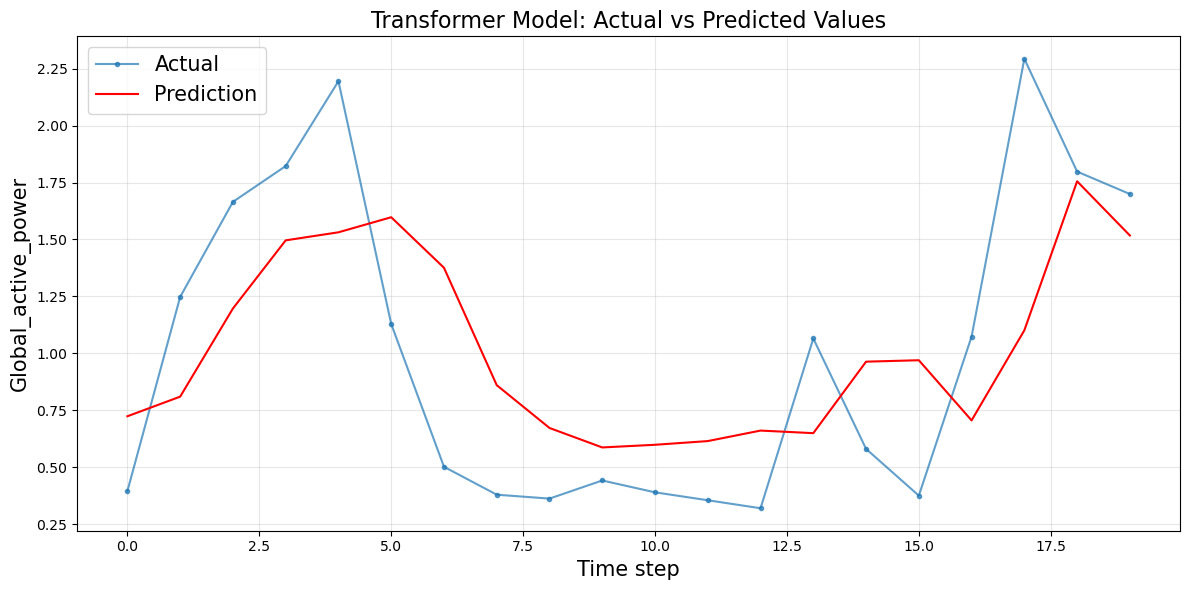

In [94]:
transformer_model.eval()
with torch.no_grad():
    test_predictions = transformer_model(test_features_tensor)
    test_error = loss_function(test_predictions, test_labels_tensor).item()
    print(f"Test Loss: {test_error:.4f}")

    predicted_values = test_predictions.numpy()

denorm_predictions = np.concatenate((
    predicted_values,
    test_features_tensor.numpy()[:, 0, -6:]
), axis=1)
denorm_predictions = normalizer.inverse_transform(denorm_predictions)
final_predictions = denorm_predictions[:, 0]

denorm_actual = np.concatenate((
    test_labels_tensor.numpy(),
    test_features_tensor.numpy()[:, 0, -6:]
), axis=1)
denorm_actual = normalizer.inverse_transform(denorm_actual)
final_actual = denorm_actual[:, 0]

error_mse = mean_squared_error(final_actual, final_predictions)
error_mae = mean_absolute_error(final_actual, final_predictions)
error_rmse = np.sqrt(error_mse)

print(f'Test MSE: {error_mse:.4f}')
print(f'Test MAE: {error_mae:.4f}')
print(f'Test RMSE: {error_rmse:.3f}')


display_count = 20
time_steps = list(range(display_count))

plt.figure(figsize=(12, 6))
plt.plot(time_steps, final_actual[:display_count], marker='.', label="Actual", alpha=0.7)
plt.plot(time_steps, final_predictions[:display_count], 'r', label="Prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.title('Transformer Model: Actual vs Predicted Values', size=16)
plt.legend(fontsize=15)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Epoch 1/50, Train Loss: 0.1005, Val Loss: 0.0102, LR: 0.001000
Epoch 2/50, Train Loss: 0.0118, Val Loss: 0.0099, LR: 0.001000
Epoch 3/50, Train Loss: 0.0111, Val Loss: 0.0096, LR: 0.001000
Epoch 4/50, Train Loss: 0.0106, Val Loss: 0.0095, LR: 0.001000
Epoch 5/50, Train Loss: 0.0105, Val Loss: 0.0095, LR: 0.001000
Epoch 6/50, Train Loss: 0.0104, Val Loss: 0.0094, LR: 0.001000
Epoch 7/50, Train Loss: 0.0103, Val Loss: 0.0094, LR: 0.001000
Epoch 8/50, Train Loss: 0.0102, Val Loss: 0.0095, LR: 0.001000
Epoch 9/50, Train Loss: 0.0100, Val Loss: 0.0091, LR: 0.001000
Epoch 10/50, Train Loss: 0.0102, Val Loss: 0.0093, LR: 0.001000
Epoch 11/50, Train Loss: 0.0100, Val Loss: 0.0093, LR: 0.001000
Epoch 12/50, Train Loss: 0.0101, Val Loss: 0.0092, LR: 0.001000
Epoch 13/50, Train Loss: 0.0099, Val Loss: 0.0091, LR: 0.001000
Epoch 14/50, Train Loss: 0.0099, Val Loss: 0.0091, LR: 0.001000
Epoch 15/50, Train Loss: 0.0098, Val Loss: 0.0091, LR: 0.001000
Epoch 16/50, Train Loss: 0.0098, Val Loss: 0.0091

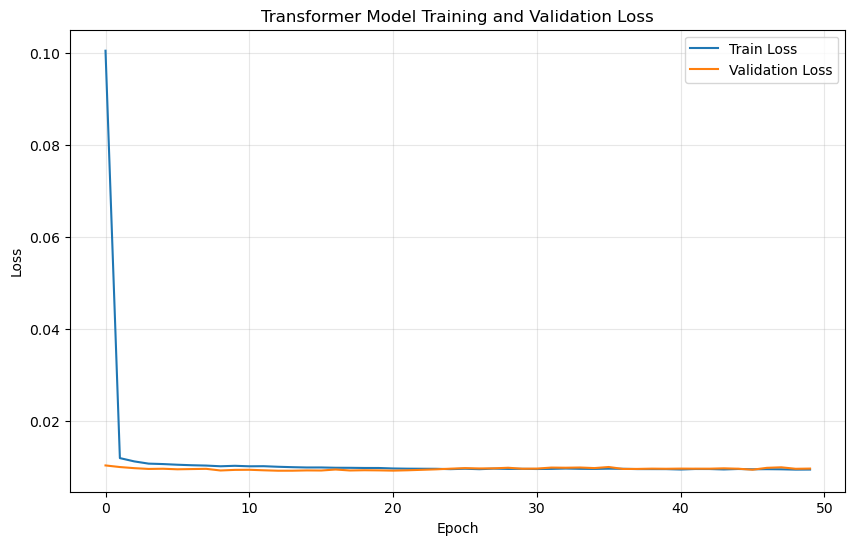

Test Loss: 0.0064
Test MSE: 0.2667
Test MAE: 0.3954
Test RMSE: 0.516


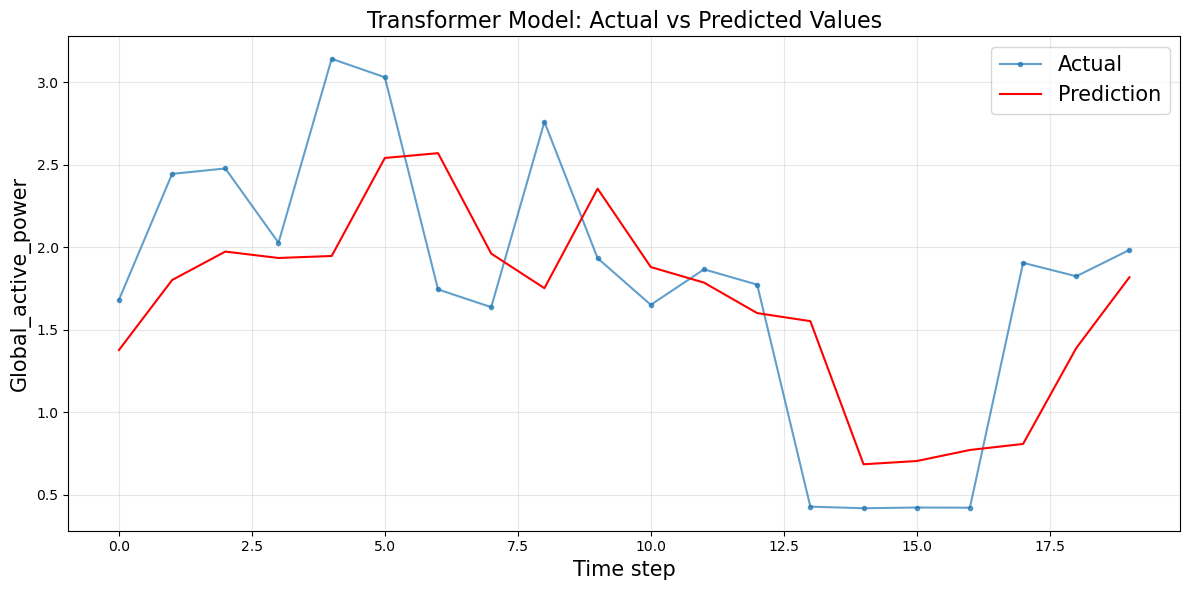

Test Loss: 0.0064
Test MSE: 0.2667
Test MAE: 0.3954
Test RMSE: 0.516


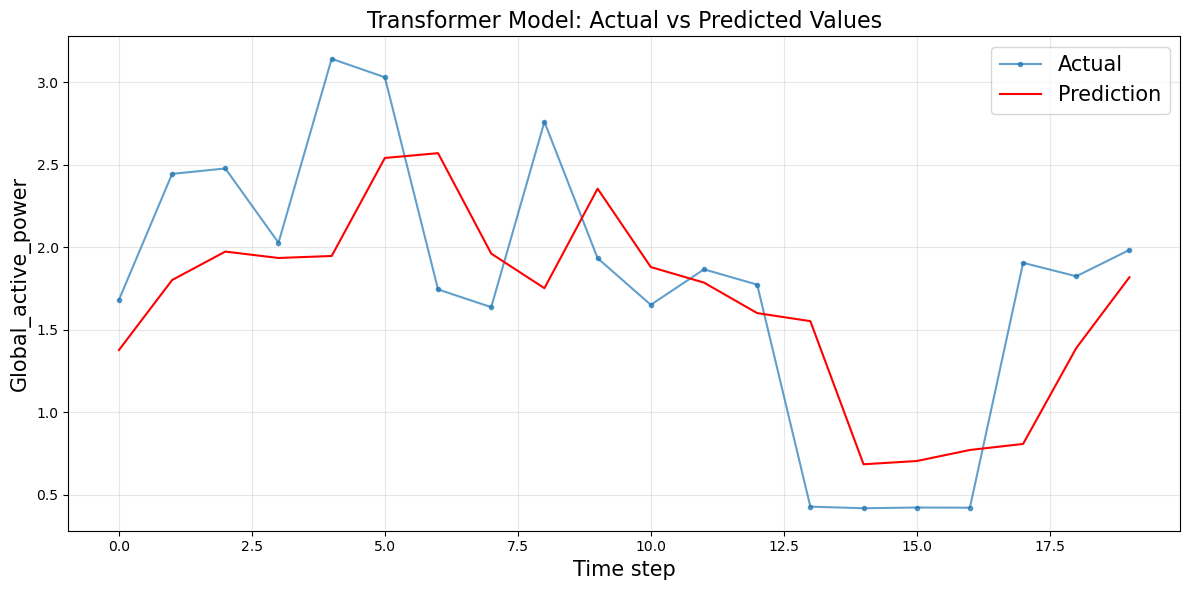

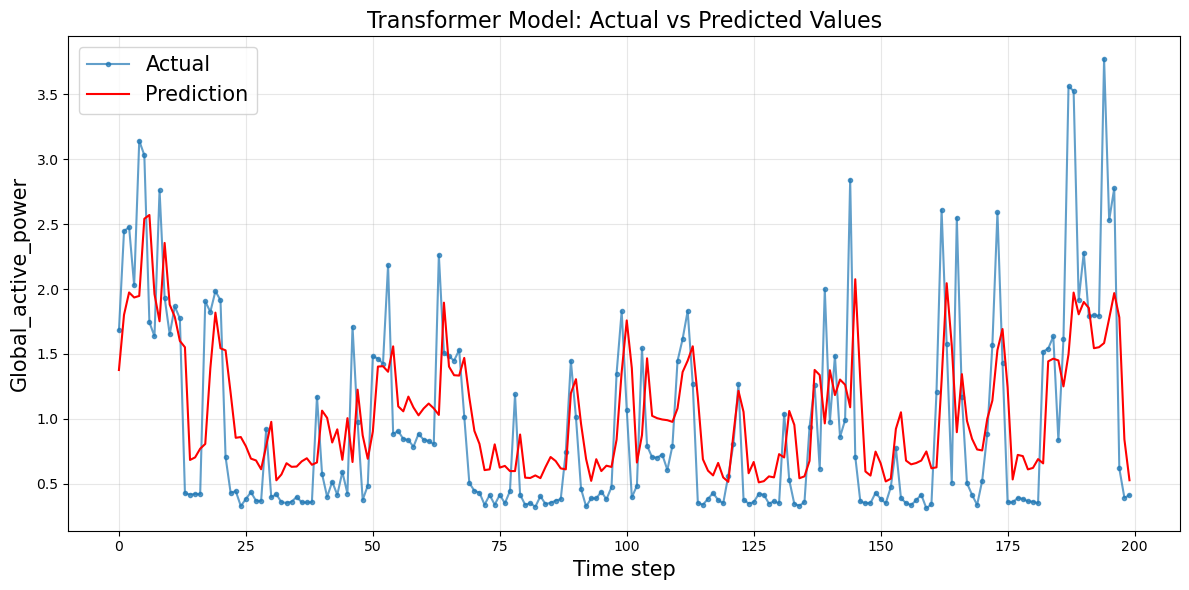

In [ ]:
from TimeSeriesTransformer import TimeSeriesTransformer

transformer_model = TimeSeriesTransformer(
    feature_dim=train_features_tensor.shape[2],  
    hidden_dim=128,                              
    output_dim=1,                                
    attention_heads=8,                           
    encoder_layers=2,                            
    dropout_rate=0.2                             
)

loss_function = nn.MSELoss()
optimizer = optim.Adam(transformer_model.parameters(), lr=0.001)

lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

early_stop_patience = 10
lowest_val_loss = float('inf')
stagnation_counter = 0

max_epochs = 50
training_history = []
validation_history = []

for epoch_idx in range(max_epochs):
    transformer_model.train()
    epoch_train_loss = 0
    
    for batch_features, batch_labels in train_data_loader:
        optimizer.zero_grad()
        predictions = transformer_model(batch_features)
        batch_loss = loss_function(predictions, batch_labels)
        
        batch_loss.backward()
        optimizer.step()
        
        epoch_train_loss += batch_loss.item()
    
    epoch_train_loss /= len(train_data_loader)
    training_history.append(epoch_train_loss)
    
    transformer_model.eval()
    epoch_val_loss = 0
    
    with torch.no_grad():
        for batch_features, batch_labels in val_data_loader:
            predictions = transformer_model(batch_features)
            batch_loss = loss_function(predictions, batch_labels)
            epoch_val_loss += batch_loss.item()
            
        epoch_val_loss /= len(val_data_loader)
        validation_history.append(epoch_val_loss)
    
    current_lr = lr_scheduler.get_last_lr()[0]
    print(f"Epoch {epoch_idx+1}/{max_epochs}, Train Loss: {epoch_train_loss:.4f}, "
          f"Val Loss: {epoch_val_loss:.4f}, LR: {current_lr:.6f}")
    
    # lr_scheduler.step()
    
    # if epoch_val_loss < lowest_val_loss:
    #     lowest_val_loss = epoch_val_loss
    #     stagnation_counter = 0
    #     # torch.save(transformer_model.state_dict(), 'best_transformer_model.pth')
    # else:
    #     stagnation_counter += 1
    #     if stagnation_counter >= early_stop_patience:
    #         print(f"Early stopping triggered after {epoch_idx+1} epochs.")
    #         break

plt.figure(figsize=(10, 6))
plt.plot(training_history, label='Train Loss')
plt.plot(validation_history, label='Validation Loss')
plt.title('Transformer Model Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.show()

transformer_model.eval()
with torch.no_grad():
    test_predictions = transformer_model(test_features_tensor)
    test_error = loss_function(test_predictions, test_labels_tensor).item()
    print(f"Test Loss: {test_error:.4f}")

    predicted_values = test_predictions.numpy()

denorm_predictions = np.concatenate((
    predicted_values,
    test_features_tensor.numpy()[:, 0, -6:]
), axis=1)
denorm_predictions = normalizer.inverse_transform(denorm_predictions)
final_predictions = denorm_predictions[:, 0]

denorm_actual = np.concatenate((
    test_labels_tensor.numpy(),
    test_features_tensor.numpy()[:, 0, -6:]
), axis=1)
denorm_actual = normalizer.inverse_transform(denorm_actual)
final_actual = denorm_actual[:, 0]

error_mse = mean_squared_error(final_actual, final_predictions)
error_mae = mean_absolute_error(final_actual, final_predictions)
error_rmse = np.sqrt(error_mse)

print(f'Test MSE: {error_mse:.4f}')
print(f'Test MAE: {error_mae:.4f}')
print(f'Test RMSE: {error_rmse:.3f}')


display_count = 20
time_steps = list(range(display_count))

plt.figure(figsize=(12, 6))
plt.plot(time_steps, final_actual[:display_count], marker='.', label="Actual", alpha=0.7)
plt.plot(time_steps, final_predictions[:display_count], 'r', label="Prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.title('Transformer Model: Actual vs Predicted Values', size=16)
plt.legend(fontsize=15)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()








Test Loss: 0.0064
Test MSE: 0.2667
Test MAE: 0.3954
Test RMSE: 0.516


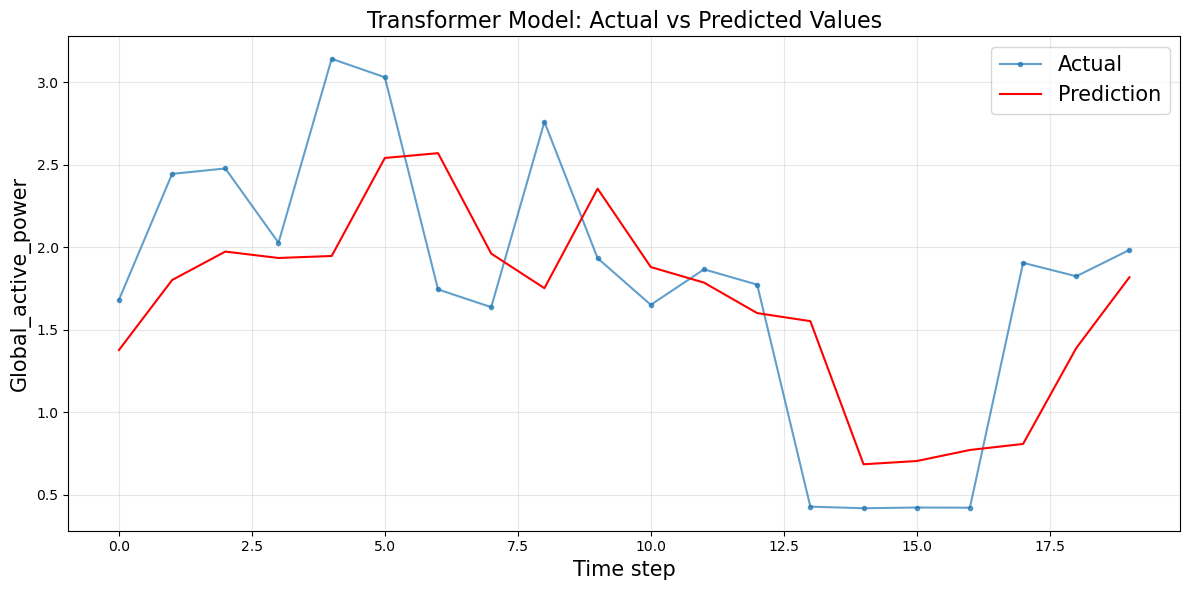

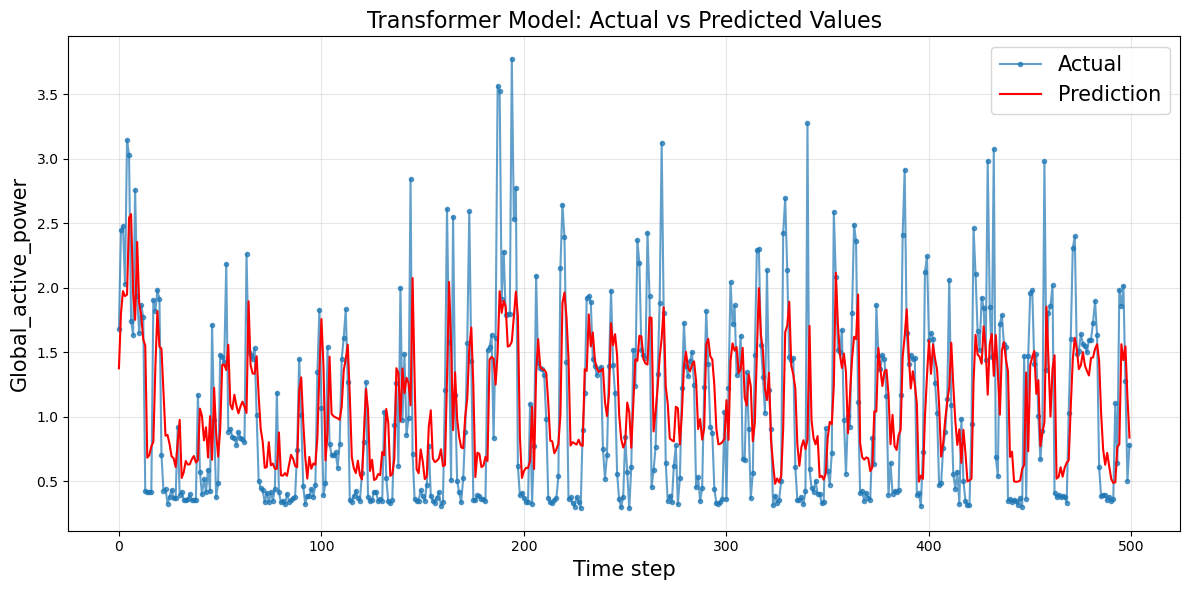

In [55]:
transformer_model.eval()
with torch.no_grad():
    test_predictions = transformer_model(test_features_tensor)
    test_error = loss_function(test_predictions, test_labels_tensor).item()
    print(f"Test Loss: {test_error:.4f}")

    predicted_values = test_predictions.numpy()

denorm_predictions = np.concatenate((
    predicted_values,
    test_features_tensor.numpy()[:, 0, -6:]
), axis=1)
denorm_predictions = normalizer.inverse_transform(denorm_predictions)
final_predictions = denorm_predictions[:, 0]

denorm_actual = np.concatenate((
    test_labels_tensor.numpy(),
    test_features_tensor.numpy()[:, 0, -6:]
), axis=1)
denorm_actual = normalizer.inverse_transform(denorm_actual)
final_actual = denorm_actual[:, 0]

error_mse = mean_squared_error(final_actual, final_predictions)
error_mae = mean_absolute_error(final_actual, final_predictions)
error_rmse = np.sqrt(error_mse)

print(f'Test MSE: {error_mse:.4f}')
print(f'Test MAE: {error_mae:.4f}')
print(f'Test RMSE: {error_rmse:.3f}')

display_count = 20
time_steps = list(range(display_count))

plt.figure(figsize=(12, 6))
plt.plot(time_steps, final_actual[:display_count], marker='.', label="Actual", alpha=0.7)
plt.plot(time_steps, final_predictions[:display_count], 'r', label="Prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.title('Transformer Model: Actual vs Predicted Values', size=16)
plt.legend(fontsize=15)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

display_count = 500
time_steps = list(range(display_count))

plt.figure(figsize=(12, 6))
plt.plot(time_steps, final_actual[:display_count], marker='.', label="Actual", alpha=0.7)
plt.plot(time_steps, final_predictions[:display_count], 'r', label="Prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.title('Transformer Model: Actual vs Predicted Values', size=16)
plt.legend(fontsize=15)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

e:\anaconda3\envs\ml\lib\site-packages\torch\nn\modules\transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/50, Train Loss: 0.1120, Val Loss: 0.0111, LR: 0.001000
Epoch 2/50, Train Loss: 0.0120, Val Loss: 0.0101, LR: 0.001000
Epoch 3/50, Train Loss: 0.0110, Val Loss: 0.0099, LR: 0.001000
Epoch 4/50, Train Loss: 0.0108, Val Loss: 0.0100, LR: 0.001000
Epoch 5/50, Train Loss: 0.0106, Val Loss: 0.0100, LR: 0.001000
Epoch 6/50, Train Loss: 0.0105, Val Loss: 0.0099, LR: 0.001000
Epoch 7/50, Train Loss: 0.0103, Val Loss: 0.0096, LR: 0.001000
Epoch 8/50, Train Loss: 0.0103, Val Loss: 0.0096, LR: 0.001000
Epoch 9/50, Train Loss: 0.0102, Val Loss: 0.0099, LR: 0.001000
Epoch 10/50, Train Loss: 0.0102, Val Loss: 0.0093, LR: 0.001000
Epoch 11/50, Train Loss: 0.0098, Val Loss: 0.0095, LR: 0.000500
Epoch 12/50, Train Loss: 0.0098, Val Loss: 0.0095, LR: 0.000500
Epoch 13/50, Train Loss: 0.0097, Val Loss: 0.0093, LR: 0.000500
Epoch 14/50, Train Loss: 0.0097, Val Loss: 0.0092, LR: 0.000500
Epoch 15/50, Train Loss: 0.0097, Val Loss: 0.0092, LR: 0.000500
Epoch 16/50, Train Loss: 0.0096, Val Loss: 0.0093

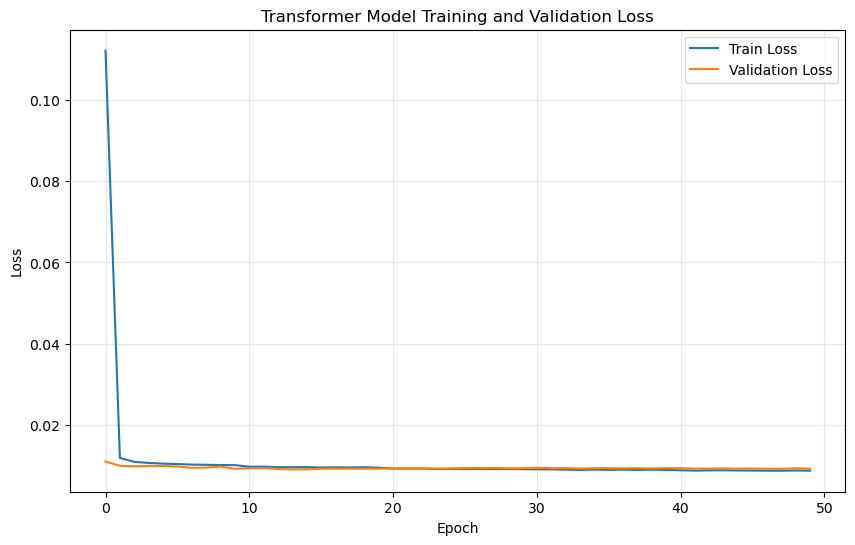

Test Loss: 0.0061
Test MSE: 0.2530
Test MAE: 0.3535
Test RMSE: 0.503


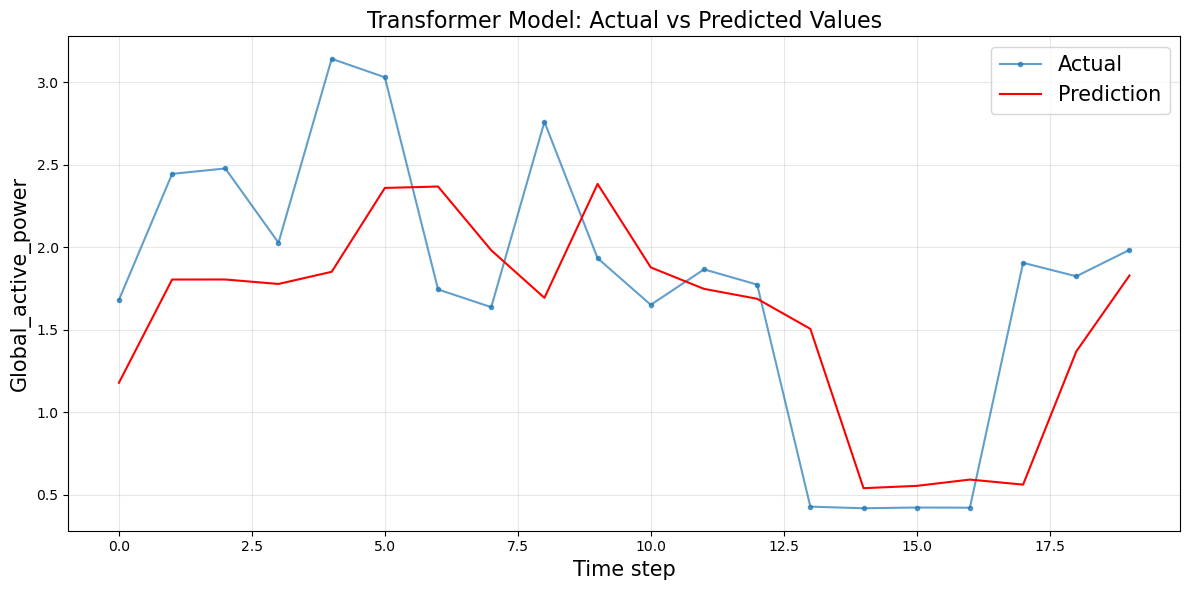

Test Loss: 0.0061
Test MSE: 0.2530
Test MAE: 0.3535
Test RMSE: 0.503


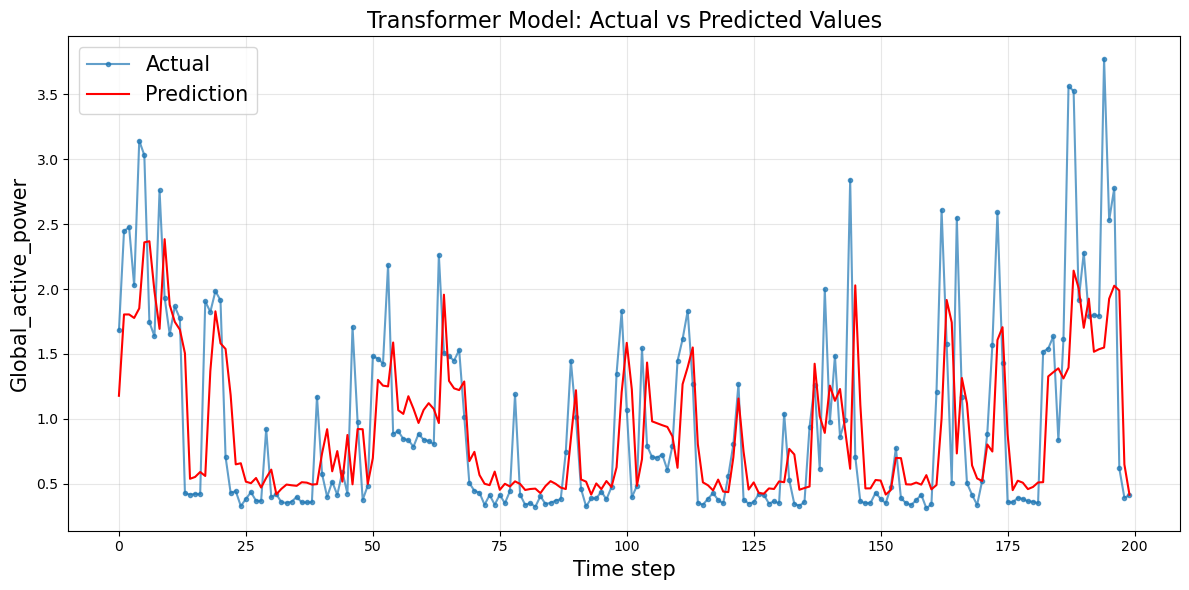

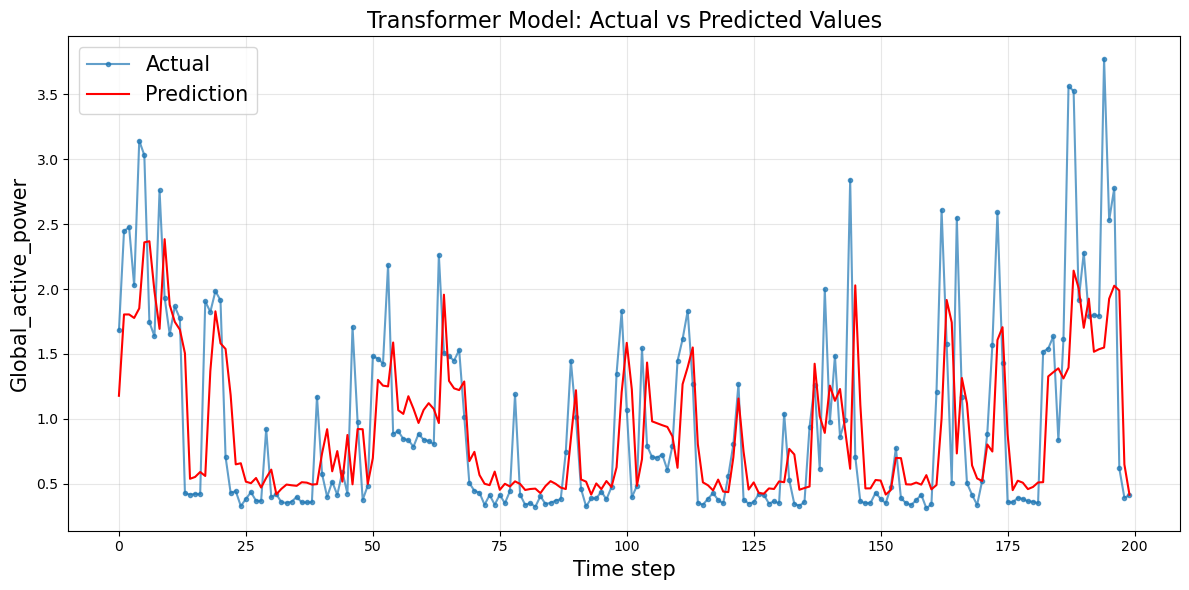

In [ ]:
####
from TimeSeriesTransformer import TimeSeriesTransformer

transformer_model = TimeSeriesTransformer(
    feature_dim=train_features_tensor.shape[2],  
    hidden_dim=128,                              
    output_dim=1,                                
    attention_heads=8,                           
    encoder_layers=2,                            
    dropout_rate=0.2                             
)

loss_function = nn.MSELoss()
optimizer = optim.Adam(transformer_model.parameters(), lr=0.001)

lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

early_stop_patience = 10
lowest_val_loss = float('inf')
stagnation_counter = 0

max_epochs = 50
training_history = []
validation_history = []

for epoch_idx in range(max_epochs):
    transformer_model.train()
    epoch_train_loss = 0
    
    for batch_features, batch_labels in train_data_loader:
        optimizer.zero_grad()
        predictions = transformer_model(batch_features)
        batch_loss = loss_function(predictions, batch_labels)
        
        batch_loss.backward()
        optimizer.step()
        
        epoch_train_loss += batch_loss.item()
    
    epoch_train_loss /= len(train_data_loader)
    training_history.append(epoch_train_loss)
    
    transformer_model.eval()
    epoch_val_loss = 0
    
    with torch.no_grad():
        for batch_features, batch_labels in val_data_loader:
            predictions = transformer_model(batch_features)
            batch_loss = loss_function(predictions, batch_labels)
            epoch_val_loss += batch_loss.item()
            
        epoch_val_loss /= len(val_data_loader)
        validation_history.append(epoch_val_loss)
    
    current_lr = lr_scheduler.get_last_lr()[0]
    print(f"Epoch {epoch_idx+1}/{max_epochs}, Train Loss: {epoch_train_loss:.4f}, "
          f"Val Loss: {epoch_val_loss:.4f}, LR: {current_lr:.6f}")
    # 
    lr_scheduler.step()
    
    # if epoch_val_loss < lowest_val_loss:
    #     lowest_val_loss = epoch_val_loss
    #     stagnation_counter = 0
        # torch.save(transformer_model.state_dict(), 'best_transformer_model.pth')
    # else:
    #     stagnation_counter += 1
    #     if stagnation_counter >= early_stop_patience:
    #         print(f"Early stopping triggered after {epoch_idx+1} epochs.")
    #         break

plt.figure(figsize=(10, 6))
plt.plot(training_history, label='Train Loss')
plt.plot(validation_history, label='Validation Loss')
plt.title('Transformer Model Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.show()

transformer_model.eval()
with torch.no_grad():
    test_predictions = transformer_model(test_features_tensor)
    test_error = loss_function(test_predictions, test_labels_tensor).item()
    print(f"Test Loss: {test_error:.4f}")

    predicted_values = test_predictions.numpy()

denorm_predictions = np.concatenate((
    predicted_values,
    test_features_tensor.numpy()[:, 0, -6:]
), axis=1)
denorm_predictions = normalizer.inverse_transform(denorm_predictions)
final_predictions = denorm_predictions[:, 0]

denorm_actual = np.concatenate((
    test_labels_tensor.numpy(),
    test_features_tensor.numpy()[:, 0, -6:]
), axis=1)
denorm_actual = normalizer.inverse_transform(denorm_actual)
final_actual = denorm_actual[:, 0]

error_mse = mean_squared_error(final_actual, final_predictions)
error_mae = mean_absolute_error(final_actual, final_predictions)
error_rmse = np.sqrt(error_mse)

print(f'Test MSE: {error_mse:.4f}')
print(f'Test MAE: {error_mae:.4f}')
print(f'Test RMSE: {error_rmse:.3f}')


display_count = 20
time_steps = list(range(display_count))

plt.figure(figsize=(12, 6))
plt.plot(time_steps, final_actual[:display_count], marker='.', label="Actual", alpha=0.7)
plt.plot(time_steps, final_predictions[:display_count], 'r', label="Prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.title('Transformer Model: Actual vs Predicted Values', size=16)
plt.legend(fontsize=15)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

transformer_model.eval()
with torch.no_grad():
    test_predictions = transformer_model(test_features_tensor)
    test_error = loss_function(test_predictions, test_labels_tensor).item()
    print(f"Test Loss: {test_error:.4f}")

    predicted_values = test_predictions.numpy()

denorm_predictions = np.concatenate((
    predicted_values,
    test_features_tensor.numpy()[:, 0, -6:]
), axis=1)
denorm_predictions = normalizer.inverse_transform(denorm_predictions)
final_predictions = denorm_predictions[:, 0]

denorm_actual = np.concatenate((
    test_labels_tensor.numpy(),
    test_features_tensor.numpy()[:, 0, -6:]
), axis=1)
denorm_actual = normalizer.inverse_transform(denorm_actual)
final_actual = denorm_actual[:, 0]

error_mse = mean_squared_error(final_actual, final_predictions)
error_mae = mean_absolute_error(final_actual, final_predictions)
error_rmse = np.sqrt(error_mse)
print(f"Test Loss: {test_error:.4f}")
print(f'Test MSE: {error_mse:.4f}')
print(f'Test MAE: {error_mae:.4f}')
print(f'Test RMSE: {error_rmse:.3f}')


display_count = 20
time_steps = list(range(display_count))

plt.figure(figsize=(12, 6))
plt.plot(time_steps, final_actual[:display_count], marker='.', label="Actual", alpha=0.7)
plt.plot(time_steps, final_predictions[:display_count], 'r', label="Prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.title('Transformer Model: Actual vs Predicted Values', size=16)
plt.legend(fontsize=15)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


display_count = 500
time_steps = list(range(display_count))

plt.figure(figsize=(12, 6))
plt.plot(time_steps, final_actual[:display_count], marker='.', label="Actual", alpha=0.7)
plt.plot(time_steps, final_predictions[:display_count], 'r', label="Prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.title('Transformer Model: Actual vs Predicted Values', size=16)
plt.legend(fontsize=15)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Test Loss: 0.0061
Test MSE: 0.2530
Test MAE: 0.3535
Test RMSE: 0.503


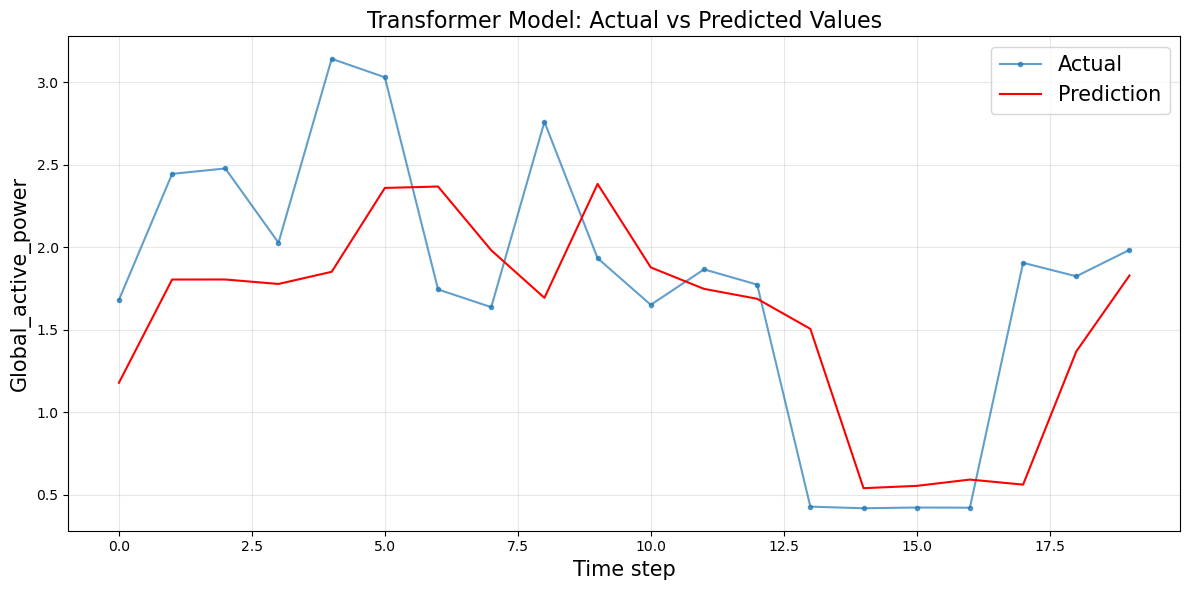

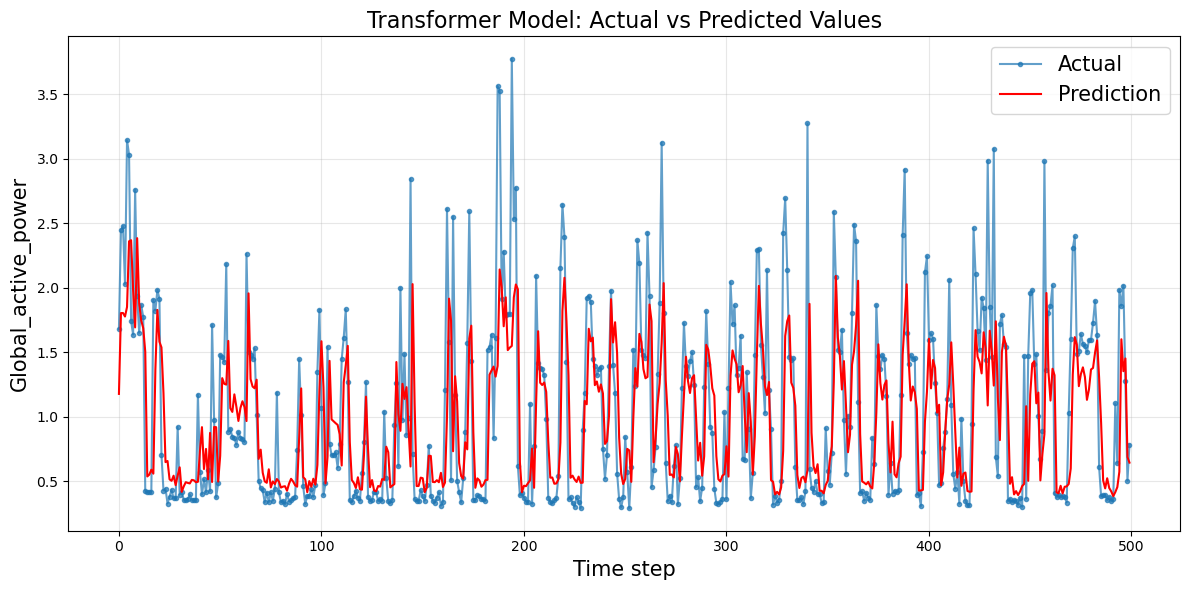

In [59]:
print(f"Test Loss: {test_error:.4f}")
print(f'Test MSE: {error_mse:.4f}')
print(f'Test MAE: {error_mae:.4f}')
print(f'Test RMSE: {error_rmse:.3f}')


display_count = 20
time_steps = list(range(display_count))

plt.figure(figsize=(12, 6))
plt.plot(time_steps, final_actual[:display_count], marker='.', label="Actual", alpha=0.7)
plt.plot(time_steps, final_predictions[:display_count], 'r', label="Prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.title('Transformer Model: Actual vs Predicted Values', size=16)
plt.legend(fontsize=15)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


display_count = 500
time_steps = list(range(display_count))

plt.figure(figsize=(12, 6))
plt.plot(time_steps, final_actual[:display_count], marker='.', label="Actual", alpha=0.7)
plt.plot(time_steps, final_predictions[:display_count], 'r', label="Prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.title('Transformer Model: Actual vs Predicted Values', size=16)
plt.legend(fontsize=15)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

e:\anaconda3\envs\ml\lib\site-packages\torch\nn\modules\transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/50, Train Loss: 0.0901, Val Loss: 0.0101, LR: 0.001000
Epoch 2/50, Train Loss: 0.0116, Val Loss: 0.0098, LR: 0.001000
Epoch 3/50, Train Loss: 0.0109, Val Loss: 0.0097, LR: 0.001000
Epoch 4/50, Train Loss: 0.0107, Val Loss: 0.0096, LR: 0.001000
Epoch 5/50, Train Loss: 0.0104, Val Loss: 0.0094, LR: 0.001000
Epoch 6/50, Train Loss: 0.0103, Val Loss: 0.0095, LR: 0.001000
Epoch 7/50, Train Loss: 0.0103, Val Loss: 0.0095, LR: 0.001000
Epoch 8/50, Train Loss: 0.0101, Val Loss: 0.0093, LR: 0.001000
Epoch 9/50, Train Loss: 0.0102, Val Loss: 0.0092, LR: 0.001000
Epoch 10/50, Train Loss: 0.0099, Val Loss: 0.0093, LR: 0.001000
Epoch 11/50, Train Loss: 0.0100, Val Loss: 0.0092, LR: 0.001000
Epoch 12/50, Train Loss: 0.0099, Val Loss: 0.0091, LR: 0.001000
Epoch 13/50, Train Loss: 0.0099, Val Loss: 0.0092, LR: 0.001000
Epoch 14/50, Train Loss: 0.0098, Val Loss: 0.0092, LR: 0.001000
Epoch 15/50, Train Loss: 0.0098, Val Loss: 0.0091, LR: 0.001000
Epoch 16/50, Train Loss: 0.0098, Val Loss: 0.0093

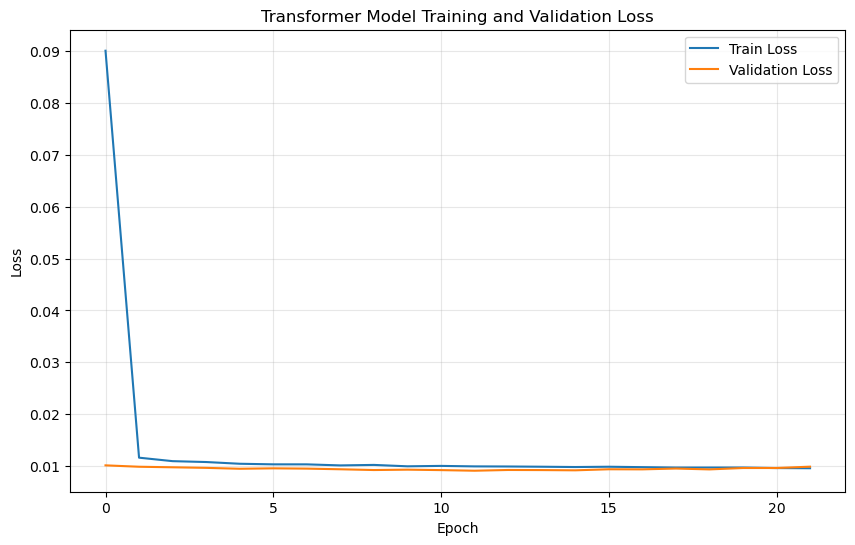

Test Loss: 0.0070
Test MSE: 0.2901
Test MAE: 0.4277
Test RMSE: 0.539


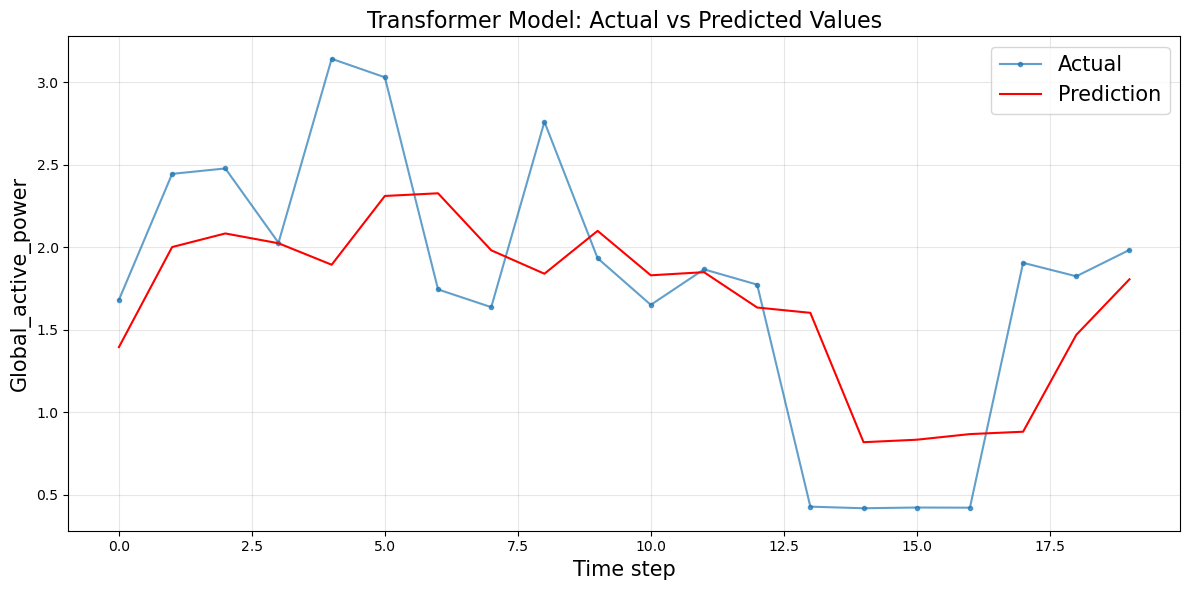

Test Loss: 0.0070
Test MSE: 0.2901
Test MAE: 0.4277
Test RMSE: 0.539


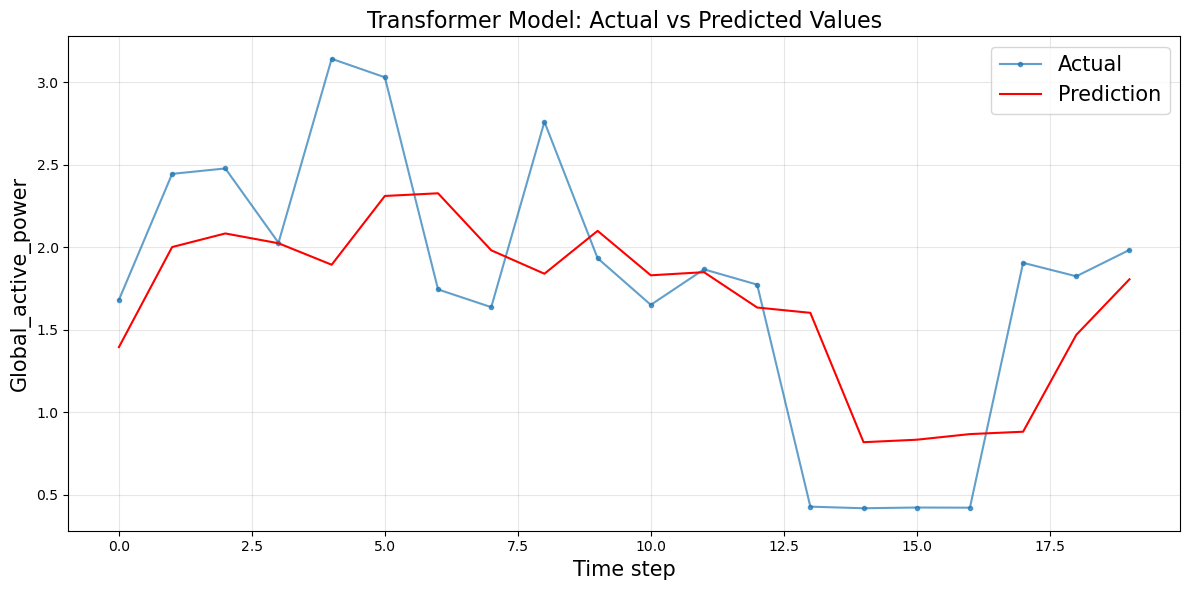

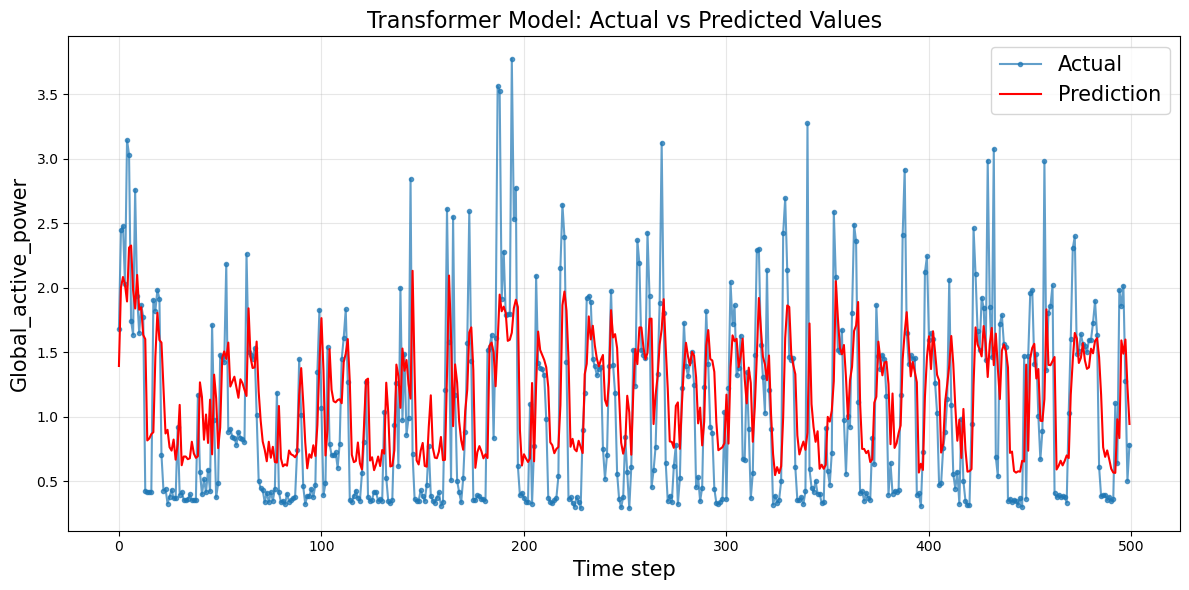

In [64]:
###
from TimeSeriesTransformer import TimeSeriesTransformer

transformer_model = TimeSeriesTransformer(
    feature_dim=train_features_tensor.shape[2],  
    hidden_dim=128,                              
    output_dim=1,                                
    attention_heads=8,                           
    encoder_layers=2,                            
    dropout_rate=0.2                             
)

loss_function = nn.MSELoss()
optimizer = optim.Adam(transformer_model.parameters(), lr=0.001)

lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

early_stop_patience = 10
lowest_val_loss = float('inf')
stagnation_counter = 0

max_epochs = 50
training_history = []
validation_history = []

for epoch_idx in range(max_epochs):
    transformer_model.train()
    epoch_train_loss = 0
    
    for batch_features, batch_labels in train_data_loader:
        optimizer.zero_grad()
        predictions = transformer_model(batch_features)
        batch_loss = loss_function(predictions, batch_labels)
        
        batch_loss.backward()
        optimizer.step()
        
        epoch_train_loss += batch_loss.item()
    
    epoch_train_loss /= len(train_data_loader)
    training_history.append(epoch_train_loss)
    
    transformer_model.eval()
    epoch_val_loss = 0
    
    with torch.no_grad():
        for batch_features, batch_labels in val_data_loader:
            predictions = transformer_model(batch_features)
            batch_loss = loss_function(predictions, batch_labels)
            epoch_val_loss += batch_loss.item()
            
        epoch_val_loss /= len(val_data_loader)
        validation_history.append(epoch_val_loss)
    
    current_lr = lr_scheduler.get_last_lr()[0]
    print(f"Epoch {epoch_idx+1}/{max_epochs}, Train Loss: {epoch_train_loss:.4f}, "
          f"Val Loss: {epoch_val_loss:.4f}, LR: {current_lr:.6f}")
    
    # lr_scheduler.step()
    
    if epoch_val_loss < lowest_val_loss:
        lowest_val_loss = epoch_val_loss
        stagnation_counter = 0
        # torch.save(transformer_model.state_dict(), 'best_transformer_model.pth')
    else:
        stagnation_counter += 1
        if stagnation_counter >= early_stop_patience:
            print(f"Early stopping triggered after {epoch_idx+1} epochs.")
            break

plt.figure(figsize=(10, 6))
plt.plot(training_history, label='Train Loss')
plt.plot(validation_history, label='Validation Loss')
plt.title('Transformer Model Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.show()

transformer_model.eval()
with torch.no_grad():
    test_predictions = transformer_model(test_features_tensor)
    test_error = loss_function(test_predictions, test_labels_tensor).item()
    print(f"Test Loss: {test_error:.4f}")

    predicted_values = test_predictions.numpy()

denorm_predictions = np.concatenate((
    predicted_values,
    test_features_tensor.numpy()[:, 0, -6:]
), axis=1)
denorm_predictions = normalizer.inverse_transform(denorm_predictions)
final_predictions = denorm_predictions[:, 0]

denorm_actual = np.concatenate((
    test_labels_tensor.numpy(),
    test_features_tensor.numpy()[:, 0, -6:]
), axis=1)
denorm_actual = normalizer.inverse_transform(denorm_actual)
final_actual = denorm_actual[:, 0]

error_mse = mean_squared_error(final_actual, final_predictions)
error_mae = mean_absolute_error(final_actual, final_predictions)
error_rmse = np.sqrt(error_mse)

print(f'Test MSE: {error_mse:.4f}')
print(f'Test MAE: {error_mae:.4f}')
print(f'Test RMSE: {error_rmse:.3f}')


display_count = 20
time_steps = list(range(display_count))

plt.figure(figsize=(12, 6))
plt.plot(time_steps, final_actual[:display_count], marker='.', label="Actual", alpha=0.7)
plt.plot(time_steps, final_predictions[:display_count], 'r', label="Prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.title('Transformer Model: Actual vs Predicted Values', size=16)
plt.legend(fontsize=15)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

transformer_model.eval()
with torch.no_grad():
    test_predictions = transformer_model(test_features_tensor)
    test_error = loss_function(test_predictions, test_labels_tensor).item()
    print(f"Test Loss: {test_error:.4f}")

    predicted_values = test_predictions.numpy()

denorm_predictions = np.concatenate((
    predicted_values,
    test_features_tensor.numpy()[:, 0, -6:]
), axis=1)
denorm_predictions = normalizer.inverse_transform(denorm_predictions)
final_predictions = denorm_predictions[:, 0]

denorm_actual = np.concatenate((
    test_labels_tensor.numpy(),
    test_features_tensor.numpy()[:, 0, -6:]
), axis=1)
denorm_actual = normalizer.inverse_transform(denorm_actual)
final_actual = denorm_actual[:, 0]

error_mse = mean_squared_error(final_actual, final_predictions)
error_mae = mean_absolute_error(final_actual, final_predictions)
error_rmse = np.sqrt(error_mse)

print(f'Test MSE: {error_mse:.4f}')
print(f'Test MAE: {error_mae:.4f}')
print(f'Test RMSE: {error_rmse:.3f}')


display_count = 20
time_steps = list(range(display_count))

plt.figure(figsize=(12, 6))
plt.plot(time_steps, final_actual[:display_count], marker='.', label="Actual", alpha=0.7)
plt.plot(time_steps, final_predictions[:display_count], 'r', label="Prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.title('Transformer Model: Actual vs Predicted Values', size=16)
plt.legend(fontsize=15)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

display_count = 500
time_steps = list(range(display_count))

plt.figure(figsize=(12, 6))
plt.plot(time_steps, final_actual[:display_count], marker='.', label="Actual", alpha=0.7)
plt.plot(time_steps, final_predictions[:display_count], 'r', label="Prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.title('Transformer Model: Actual vs Predicted Values', size=16)
plt.legend(fontsize=15)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()




e:\anaconda3\envs\ml\lib\site-packages\torch\nn\modules\transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/50, Train Loss: 0.1119, Val Loss: 0.0101, LR: 0.001000
Epoch 2/50, Train Loss: 0.0120, Val Loss: 0.0099, LR: 0.001000
Epoch 3/50, Train Loss: 0.0111, Val Loss: 0.0100, LR: 0.001000
Epoch 4/50, Train Loss: 0.0109, Val Loss: 0.0099, LR: 0.001000
Epoch 5/50, Train Loss: 0.0104, Val Loss: 0.0096, LR: 0.001000
Epoch 6/50, Train Loss: 0.0104, Val Loss: 0.0095, LR: 0.001000
Epoch 7/50, Train Loss: 0.0102, Val Loss: 0.0095, LR: 0.001000
Epoch 8/50, Train Loss: 0.0102, Val Loss: 0.0095, LR: 0.001000
Epoch 9/50, Train Loss: 0.0101, Val Loss: 0.0094, LR: 0.001000
Epoch 10/50, Train Loss: 0.0102, Val Loss: 0.0094, LR: 0.001000
Epoch 11/50, Train Loss: 0.0099, Val Loss: 0.0097, LR: 0.000500
Epoch 12/50, Train Loss: 0.0098, Val Loss: 0.0096, LR: 0.000500
Epoch 13/50, Train Loss: 0.0099, Val Loss: 0.0095, LR: 0.000500
Epoch 14/50, Train Loss: 0.0098, Val Loss: 0.0095, LR: 0.000500
Epoch 15/50, Train Loss: 0.0097, Val Loss: 0.0095, LR: 0.000500
Epoch 16/50, Train Loss: 0.0097, Val Loss: 0.0096

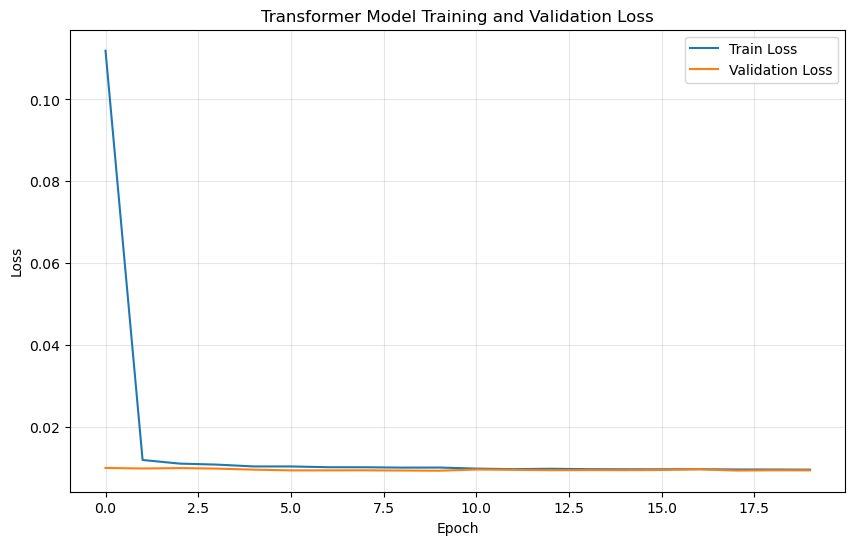

Test Loss: 0.0067
Test MSE: 0.2788
Test MAE: 0.4175
Test RMSE: 0.528


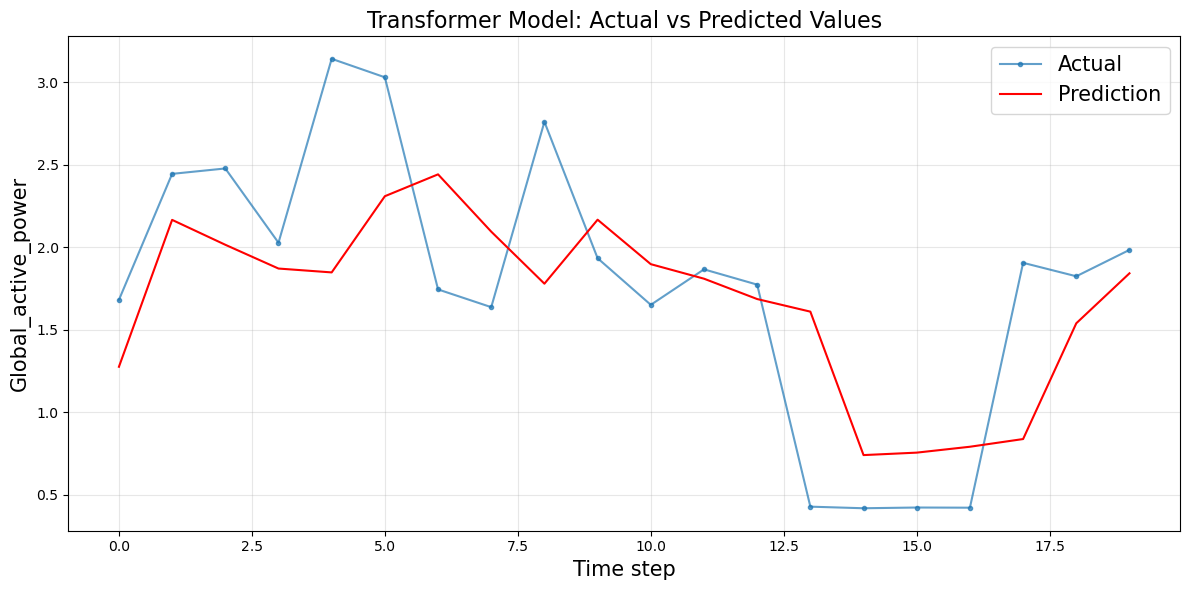

Test Loss: 0.0067
Test MSE: 0.2788
Test MAE: 0.4175
Test RMSE: 0.528


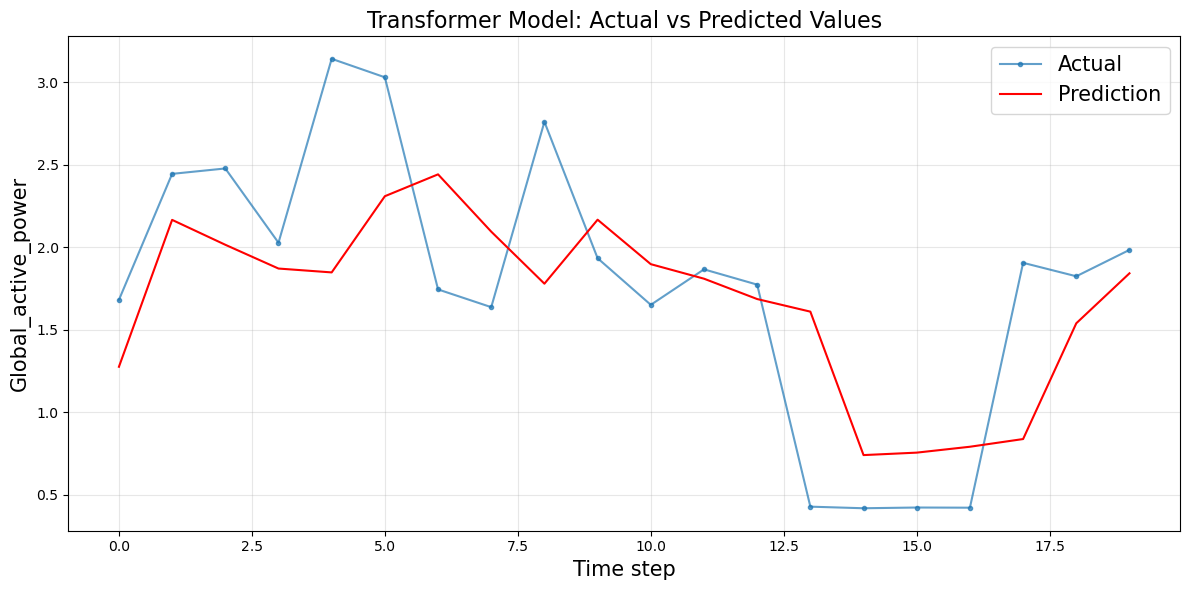

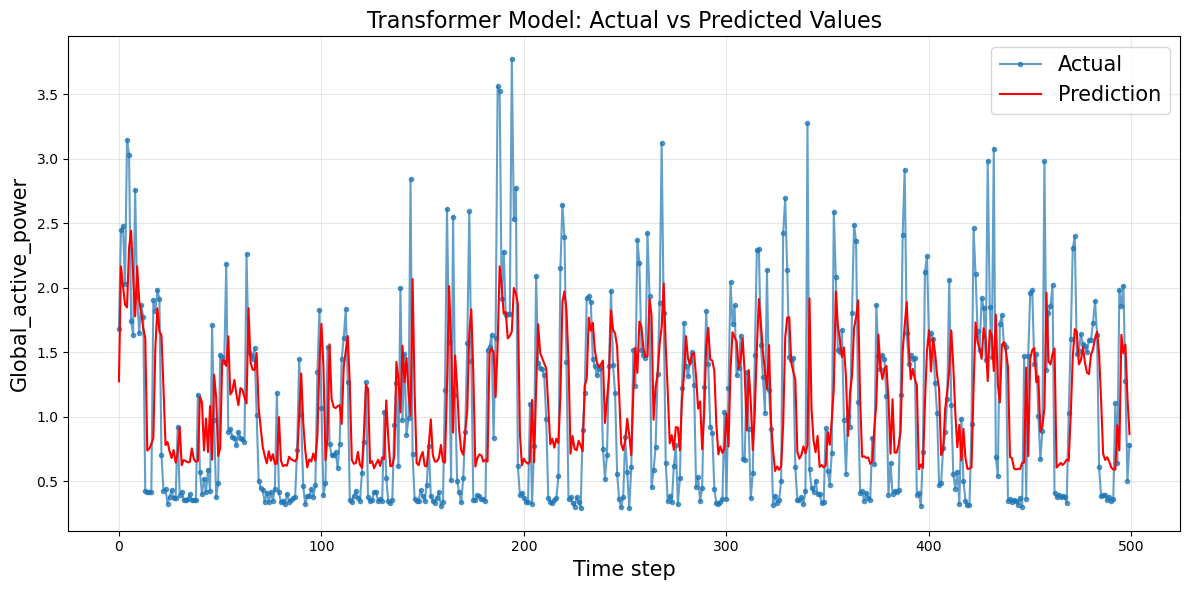

In [65]:
####
from TimeSeriesTransformer import TimeSeriesTransformer

transformer_model = TimeSeriesTransformer(
    feature_dim=train_features_tensor.shape[2],  
    hidden_dim=128,                              
    output_dim=1,                                
    attention_heads=8,                           
    encoder_layers=2,                            
    dropout_rate=0.2                             
)

loss_function = nn.MSELoss()
optimizer = optim.Adam(transformer_model.parameters(), lr=0.001)

lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

early_stop_patience = 10
lowest_val_loss = float('inf')
stagnation_counter = 0

max_epochs = 50
training_history = []
validation_history = []

for epoch_idx in range(max_epochs):
    transformer_model.train()
    epoch_train_loss = 0
    
    for batch_features, batch_labels in train_data_loader:
        optimizer.zero_grad()
        predictions = transformer_model(batch_features)
        batch_loss = loss_function(predictions, batch_labels)
        
        batch_loss.backward()
        optimizer.step()
        
        epoch_train_loss += batch_loss.item()
    
    epoch_train_loss /= len(train_data_loader)
    training_history.append(epoch_train_loss)
    
    transformer_model.eval()
    epoch_val_loss = 0
    
    with torch.no_grad():
        for batch_features, batch_labels in val_data_loader:
            predictions = transformer_model(batch_features)
            batch_loss = loss_function(predictions, batch_labels)
            epoch_val_loss += batch_loss.item()
            
        epoch_val_loss /= len(val_data_loader)
        validation_history.append(epoch_val_loss)
    
    current_lr = lr_scheduler.get_last_lr()[0]
    print(f"Epoch {epoch_idx+1}/{max_epochs}, Train Loss: {epoch_train_loss:.4f}, "
          f"Val Loss: {epoch_val_loss:.4f}, LR: {current_lr:.6f}")
    
    lr_scheduler.step()
    
    if epoch_val_loss < lowest_val_loss:
        lowest_val_loss = epoch_val_loss
        stagnation_counter = 0
        # torch.save(transformer_model.state_dict(), 'best_transformer_model.pth')
    else:
        stagnation_counter += 1
        if stagnation_counter >= early_stop_patience:
            print(f"Early stopping triggered after {epoch_idx+1} epochs.")
            break

plt.figure(figsize=(10, 6))
plt.plot(training_history, label='Train Loss')
plt.plot(validation_history, label='Validation Loss')
plt.title('Transformer Model Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.show()

transformer_model.eval()
with torch.no_grad():
    test_predictions = transformer_model(test_features_tensor)
    test_error = loss_function(test_predictions, test_labels_tensor).item()
    print(f"Test Loss: {test_error:.4f}")

    predicted_values = test_predictions.numpy()

denorm_predictions = np.concatenate((
    predicted_values,
    test_features_tensor.numpy()[:, 0, -6:]
), axis=1)
denorm_predictions = normalizer.inverse_transform(denorm_predictions)
final_predictions = denorm_predictions[:, 0]

denorm_actual = np.concatenate((
    test_labels_tensor.numpy(),
    test_features_tensor.numpy()[:, 0, -6:]
), axis=1)
denorm_actual = normalizer.inverse_transform(denorm_actual)
final_actual = denorm_actual[:, 0]

error_mse = mean_squared_error(final_actual, final_predictions)
error_mae = mean_absolute_error(final_actual, final_predictions)
error_rmse = np.sqrt(error_mse)

print(f'Test MSE: {error_mse:.4f}')
print(f'Test MAE: {error_mae:.4f}')
print(f'Test RMSE: {error_rmse:.3f}')


display_count = 20
time_steps = list(range(display_count))

plt.figure(figsize=(12, 6))
plt.plot(time_steps, final_actual[:display_count], marker='.', label="Actual", alpha=0.7)
plt.plot(time_steps, final_predictions[:display_count], 'r', label="Prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.title('Transformer Model: Actual vs Predicted Values', size=16)
plt.legend(fontsize=15)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

transformer_model.eval()
with torch.no_grad():
    test_predictions = transformer_model(test_features_tensor)
    test_error = loss_function(test_predictions, test_labels_tensor).item()
    print(f"Test Loss: {test_error:.4f}")

    predicted_values = test_predictions.numpy()

denorm_predictions = np.concatenate((
    predicted_values,
    test_features_tensor.numpy()[:, 0, -6:]
), axis=1)
denorm_predictions = normalizer.inverse_transform(denorm_predictions)
final_predictions = denorm_predictions[:, 0]

denorm_actual = np.concatenate((
    test_labels_tensor.numpy(),
    test_features_tensor.numpy()[:, 0, -6:]
), axis=1)
denorm_actual = normalizer.inverse_transform(denorm_actual)
final_actual = denorm_actual[:, 0]

error_mse = mean_squared_error(final_actual, final_predictions)
error_mae = mean_absolute_error(final_actual, final_predictions)
error_rmse = np.sqrt(error_mse)

print(f'Test MSE: {error_mse:.4f}')
print(f'Test MAE: {error_mae:.4f}')
print(f'Test RMSE: {error_rmse:.3f}')


display_count = 20
time_steps = list(range(display_count))

plt.figure(figsize=(12, 6))
plt.plot(time_steps, final_actual[:display_count], marker='.', label="Actual", alpha=0.7)
plt.plot(time_steps, final_predictions[:display_count], 'r', label="Prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.title('Transformer Model: Actual vs Predicted Values', size=16)
plt.legend(fontsize=15)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

display_count = 500
time_steps = list(range(display_count))

plt.figure(figsize=(12, 6))
plt.plot(time_steps, final_actual[:display_count], marker='.', label="Actual", alpha=0.7)
plt.plot(time_steps, final_predictions[:display_count], 'r', label="Prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.title('Transformer Model: Actual vs Predicted Values', size=16)
plt.legend(fontsize=15)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
display_count = 500
time_steps = list(range(display_count))

plt.figure(figsize=(12, 6))
plt.plot(time_steps, final_actual[:display_count], marker='.', label="Actual", alpha=0.7)
plt.plot(time_steps, final_predictions[:display_count], 'r', label="Prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.title('Transformer Model: Actual vs Predicted Values', size=16)
plt.legend(fontsize=15)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Epoch 1/50, Train Loss: 0.0150, Val Loss: 0.0124, LR: 0.001000
Epoch 2/50, Train Loss: 0.0103, Val Loss: 0.0105, LR: 0.001000
Epoch 3/50, Train Loss: 0.0097, Val Loss: 0.0103, LR: 0.001000
Epoch 4/50, Train Loss: 0.0096, Val Loss: 0.0102, LR: 0.001000
Epoch 5/50, Train Loss: 0.0095, Val Loss: 0.0103, LR: 0.001000
Epoch 6/50, Train Loss: 0.0094, Val Loss: 0.0104, LR: 0.001000
Epoch 7/50, Train Loss: 0.0095, Val Loss: 0.0104, LR: 0.001000
Epoch 8/50, Train Loss: 0.0094, Val Loss: 0.0106, LR: 0.001000
Epoch 9/50, Train Loss: 0.0094, Val Loss: 0.0106, LR: 0.001000
Epoch 10/50, Train Loss: 0.0094, Val Loss: 0.0106, LR: 0.001000
Epoch 11/50, Train Loss: 0.0094, Val Loss: 0.0106, LR: 0.001000
Epoch 12/50, Train Loss: 0.0094, Val Loss: 0.0107, LR: 0.001000
Epoch 13/50, Train Loss: 0.0094, Val Loss: 0.0108, LR: 0.001000
Epoch 14/50, Train Loss: 0.0094, Val Loss: 0.0108, LR: 0.001000
Epoch 15/50, Train Loss: 0.0094, Val Loss: 0.0108, LR: 0.001000
Epoch 16/50, Train Loss: 0.0093, Val Loss: 0.0108

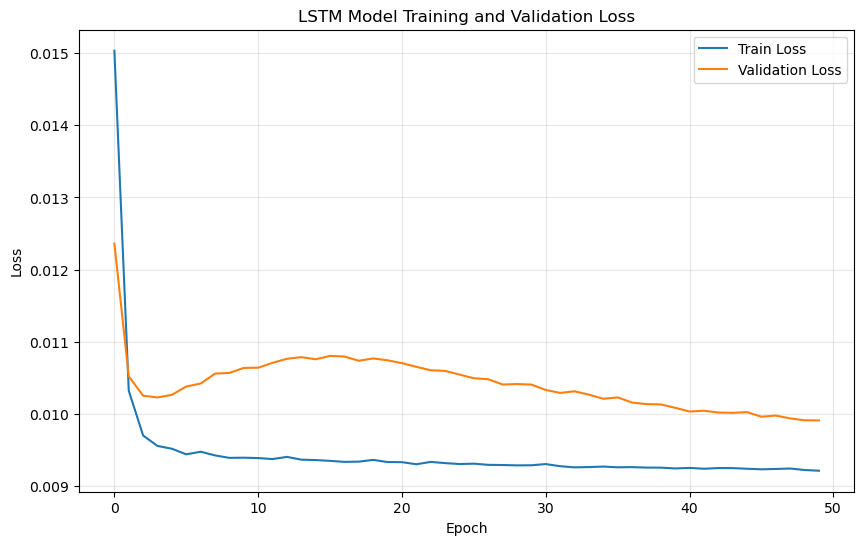

Test Loss: 0.0065
Test MSE: 0.2676
Test MAE: 0.3736
Test RMSE: 0.517


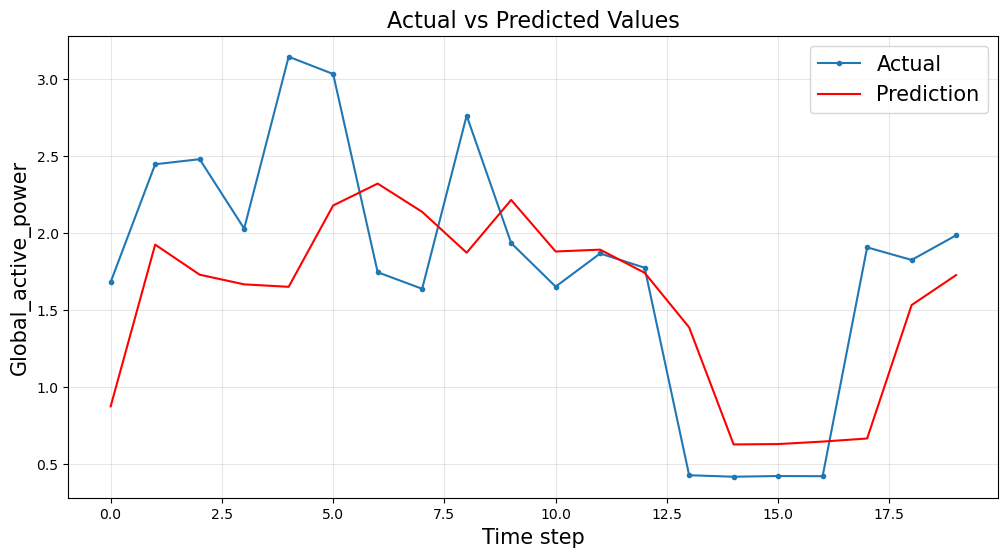

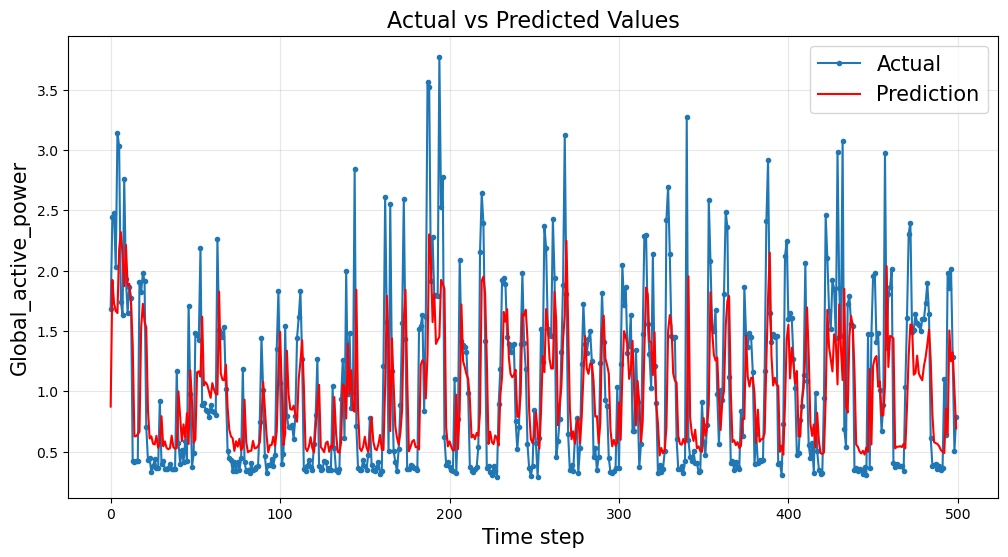

In [ ]:
## lstm no early stopping no learning rate schedule

from TimeSeriesLSTM import TimeSeriesLSTM

lstm_model = TimeSeriesLSTM(
    feature_dim=train_features_tensor.shape[2], 
    hidden_dim=100, 
    output_dim=1
)

loss_function = nn.MSELoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

early_stop_patience = 10
lowest_val_loss = float('inf')
stagnation_counter = 0

max_epochs = 50
training_history = []
validation_history = []

for epoch_idx in range(max_epochs):
    lstm_model.train()
    epoch_train_loss = 0
    for batch_features, batch_labels in train_data_loader:
        optimizer.zero_grad()
        predictions = lstm_model(batch_features)
        batch_loss = loss_function(predictions, batch_labels)
        
        batch_loss.backward()
        optimizer.step()
        epoch_train_loss += batch_loss.item()
    
    epoch_train_loss /= len(train_data_loader)
    training_history.append(epoch_train_loss)

    lstm_model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for batch_features, batch_labels in val_data_loader:
            predictions = lstm_model(batch_features)
            batch_loss = loss_function(predictions, batch_labels)
            epoch_val_loss += batch_loss.item()
        
        epoch_val_loss /= len(val_data_loader)
        validation_history.append(epoch_val_loss)

    current_lr = lr_scheduler.get_last_lr()[0]
    print(f"Epoch {epoch_idx+1}/{max_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, LR: {current_lr:.6f}")
    
    # lr_scheduler.step()

    # if epoch_val_loss < lowest_val_loss:
    #     lowest_val_loss = epoch_val_loss
    #     stagnation_counter = 0
    # else:
    #     stagnation_counter += 1
    #     if stagnation_counter >= early_stop_patience:
    #         print(f"Early stopping triggered after {epoch_idx+1} epochs.")
    #         break

plt.figure(figsize=(10, 6))
plt.plot(training_history, label='Train Loss')
plt.plot(validation_history, label='Validation Loss')
plt.title('LSTM Model Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.show()

lstm_model.eval()
with torch.no_grad():
    test_predictions = lstm_model(test_features_tensor)
    test_error = loss_function(test_predictions, test_labels_tensor).item()
    print(f"Test Loss: {test_error:.4f}")
    
    predicted_values = test_predictions.numpy()

denorm_predictions = np.concatenate((
    predicted_values,
    test_features_tensor.numpy()[:, 0, -6:]
), axis=1)
denorm_predictions = normalizer.inverse_transform(denorm_predictions)
final_predictions = denorm_predictions[:, 0]

denorm_actual = np.concatenate((
    test_labels_tensor.numpy(),
    test_features_tensor.numpy()[:, 0, -6:]
), axis=1)
denorm_actual = normalizer.inverse_transform(denorm_actual)
final_actual = denorm_actual[:, 0]

error_mse = mean_squared_error(final_actual, final_predictions)
error_mae = mean_absolute_error(final_actual, final_predictions)
error_rmse = np.sqrt(error_mse)

print(f'Test MSE: {error_mse:.4f}')
print(f'Test MAE: {error_mae:.4f}')
print(f'Test RMSE: {error_rmse:.3f}')

display_count = 20
time_indices = list(range(display_count))

plt.figure(figsize=(12, 6))
plt.plot(time_indices, final_actual[:display_count], marker='.', label="Actual")
plt.plot(time_indices, final_predictions[:display_count], 'r', label="Prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.title('Actual vs Predicted Values', size=16)
plt.legend(fontsize=15)
plt.grid(True, alpha=0.3)
plt.show()

display_count = 500
time_indices = list(range(display_count))

plt.figure(figsize=(12, 6))
plt.plot(time_indices, final_actual[:display_count], marker='.', label="Actual")
plt.plot(time_indices, final_predictions[:display_count], 'r', label="Prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.title('Actual vs Predicted Values', size=16)
plt.legend(fontsize=15)
plt.grid(True, alpha=0.3)
plt.show()



Epoch 1/50, Train Loss: 0.0152, Val Loss: 0.0124, LR: 0.001000
Epoch 2/50, Train Loss: 0.0104, Val Loss: 0.0107, LR: 0.001000
Epoch 3/50, Train Loss: 0.0097, Val Loss: 0.0102, LR: 0.001000
Epoch 4/50, Train Loss: 0.0095, Val Loss: 0.0103, LR: 0.001000
Epoch 5/50, Train Loss: 0.0095, Val Loss: 0.0103, LR: 0.001000
Epoch 6/50, Train Loss: 0.0095, Val Loss: 0.0104, LR: 0.001000
Epoch 7/50, Train Loss: 0.0094, Val Loss: 0.0105, LR: 0.001000
Epoch 8/50, Train Loss: 0.0094, Val Loss: 0.0105, LR: 0.001000
Epoch 9/50, Train Loss: 0.0094, Val Loss: 0.0106, LR: 0.001000
Epoch 10/50, Train Loss: 0.0094, Val Loss: 0.0107, LR: 0.001000
Epoch 11/50, Train Loss: 0.0094, Val Loss: 0.0113, LR: 0.000500
Epoch 12/50, Train Loss: 0.0094, Val Loss: 0.0112, LR: 0.000500
Epoch 13/50, Train Loss: 0.0094, Val Loss: 0.0112, LR: 0.000500
Epoch 14/50, Train Loss: 0.0093, Val Loss: 0.0112, LR: 0.000500
Epoch 15/50, Train Loss: 0.0094, Val Loss: 0.0112, LR: 0.000500
Epoch 16/50, Train Loss: 0.0094, Val Loss: 0.0111

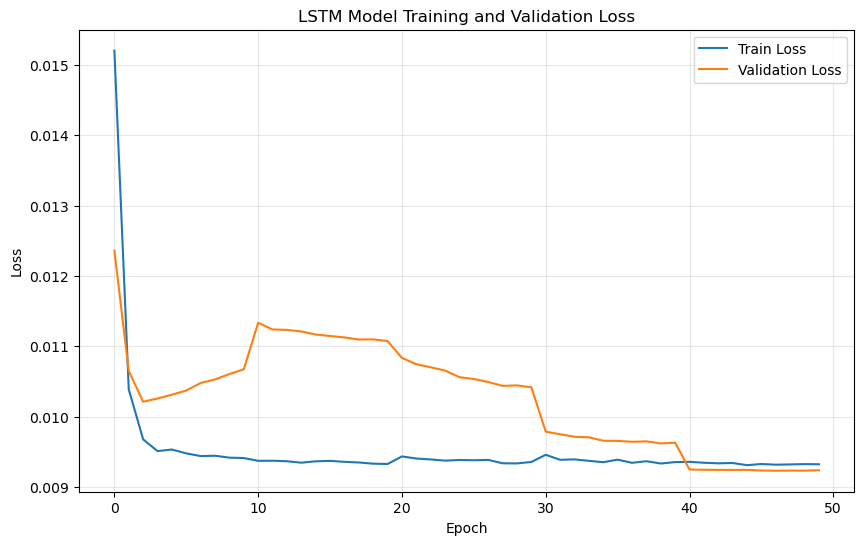

Test Loss: 0.0065
Test MSE: 0.2674
Test MAE: 0.3629
Test RMSE: 0.517


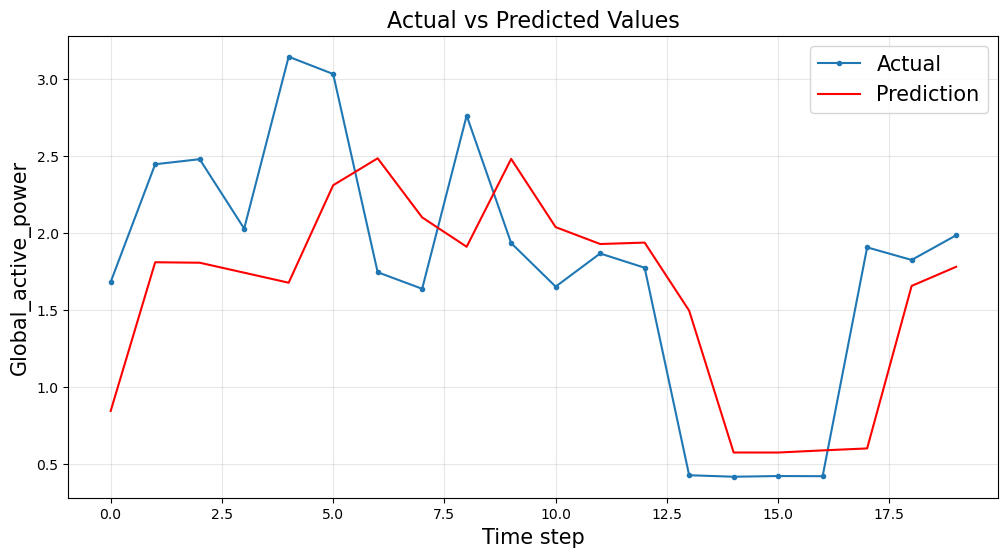

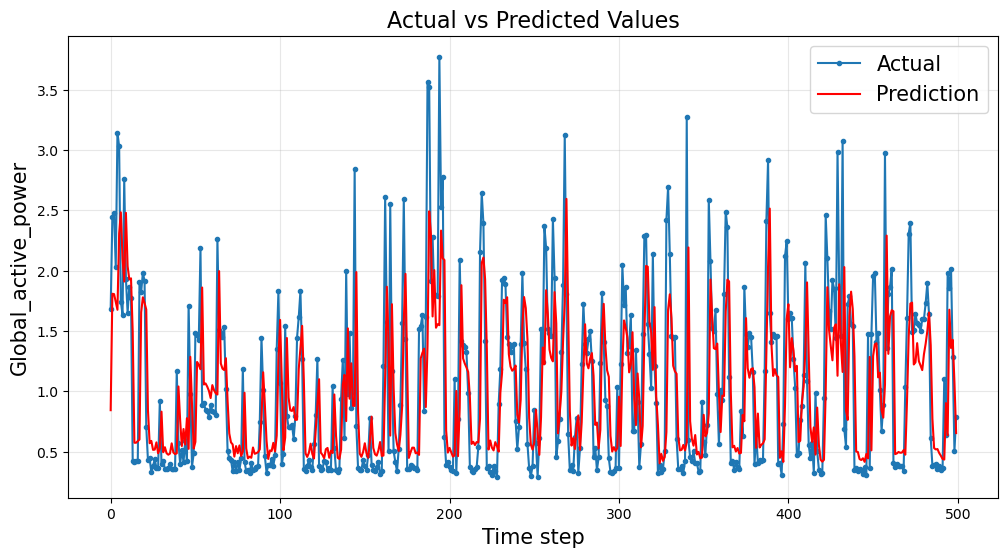

In [ ]:
## lstm no early stopping learning rate schedule

from TimeSeriesLSTM import TimeSeriesLSTM

lstm_model = TimeSeriesLSTM(
    feature_dim=train_features_tensor.shape[2], 
    hidden_dim=100, 
    output_dim=1
)

loss_function = nn.MSELoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

early_stop_patience = 10
lowest_val_loss = float('inf')
stagnation_counter = 0

max_epochs = 50
training_history = []
validation_history = []

for epoch_idx in range(max_epochs):
    lstm_model.train()
    epoch_train_loss = 0
    for batch_features, batch_labels in train_data_loader:
        optimizer.zero_grad()
        predictions = lstm_model(batch_features)
        batch_loss = loss_function(predictions, batch_labels)
        
        batch_loss.backward()
        optimizer.step()
        epoch_train_loss += batch_loss.item()
    
    epoch_train_loss /= len(train_data_loader)
    training_history.append(epoch_train_loss)

    lstm_model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for batch_features, batch_labels in val_data_loader:
            predictions = lstm_model(batch_features)
            batch_loss = loss_function(predictions, batch_labels)
            epoch_val_loss += batch_loss.item()
        
        epoch_val_loss /= len(val_data_loader)
        validation_history.append(epoch_val_loss)

    current_lr = lr_scheduler.get_last_lr()[0]
    print(f"Epoch {epoch_idx+1}/{max_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, LR: {current_lr:.6f}")
    
    lr_scheduler.step()

    # if epoch_val_loss < lowest_val_loss:
    #     lowest_val_loss = epoch_val_loss
    #     stagnation_counter = 0
    # else:
    #     stagnation_counter += 1
    #     if stagnation_counter >= early_stop_patience:
    #         print(f"Early stopping triggered after {epoch_idx+1} epochs.")
    #         break

plt.figure(figsize=(10, 6))
plt.plot(training_history, label='Train Loss')
plt.plot(validation_history, label='Validation Loss')
plt.title('LSTM Model Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.show()

lstm_model.eval()
with torch.no_grad():
    test_predictions = lstm_model(test_features_tensor)
    test_error = loss_function(test_predictions, test_labels_tensor).item()
    print(f"Test Loss: {test_error:.4f}")
    
    predicted_values = test_predictions.numpy()

denorm_predictions = np.concatenate((
    predicted_values,
    test_features_tensor.numpy()[:, 0, -6:]
), axis=1)
denorm_predictions = normalizer.inverse_transform(denorm_predictions)
final_predictions = denorm_predictions[:, 0]

denorm_actual = np.concatenate((
    test_labels_tensor.numpy(),
    test_features_tensor.numpy()[:, 0, -6:]
), axis=1)
denorm_actual = normalizer.inverse_transform(denorm_actual)
final_actual = denorm_actual[:, 0]

error_mse = mean_squared_error(final_actual, final_predictions)
error_mae = mean_absolute_error(final_actual, final_predictions)
error_rmse = np.sqrt(error_mse)

print(f'Test MSE: {error_mse:.4f}')
print(f'Test MAE: {error_mae:.4f}')
print(f'Test RMSE: {error_rmse:.3f}')

display_count = 20
time_indices = list(range(display_count))

plt.figure(figsize=(12, 6))
plt.plot(time_indices, final_actual[:display_count], marker='.', label="Actual")
plt.plot(time_indices, final_predictions[:display_count], 'r', label="Prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.title('Actual vs Predicted Values', size=16)
plt.legend(fontsize=15)
plt.grid(True, alpha=0.3)
plt.show()

display_count = 500
time_indices = list(range(display_count))

plt.figure(figsize=(12, 6))
plt.plot(time_indices, final_actual[:display_count], marker='.', label="Actual")
plt.plot(time_indices, final_predictions[:display_count], 'r', label="Prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.title('Actual vs Predicted Values', size=16)
plt.legend(fontsize=15)
plt.grid(True, alpha=0.3)
plt.show()



Epoch 1/50, Train Loss: 0.0140, Val Loss: 0.0120, LR: 0.001000
Epoch 2/50, Train Loss: 0.0102, Val Loss: 0.0106, LR: 0.001000
Epoch 3/50, Train Loss: 0.0096, Val Loss: 0.0104, LR: 0.001000
Epoch 4/50, Train Loss: 0.0095, Val Loss: 0.0105, LR: 0.001000
Epoch 5/50, Train Loss: 0.0095, Val Loss: 0.0105, LR: 0.001000
Epoch 6/50, Train Loss: 0.0094, Val Loss: 0.0107, LR: 0.001000
Epoch 7/50, Train Loss: 0.0094, Val Loss: 0.0107, LR: 0.001000
Epoch 8/50, Train Loss: 0.0094, Val Loss: 0.0108, LR: 0.001000
Epoch 9/50, Train Loss: 0.0094, Val Loss: 0.0108, LR: 0.001000
Epoch 10/50, Train Loss: 0.0094, Val Loss: 0.0107, LR: 0.001000
Epoch 11/50, Train Loss: 0.0094, Val Loss: 0.0108, LR: 0.001000
Epoch 12/50, Train Loss: 0.0094, Val Loss: 0.0108, LR: 0.001000
Epoch 13/50, Train Loss: 0.0094, Val Loss: 0.0107, LR: 0.001000
Early stopping triggered after 13 epochs.


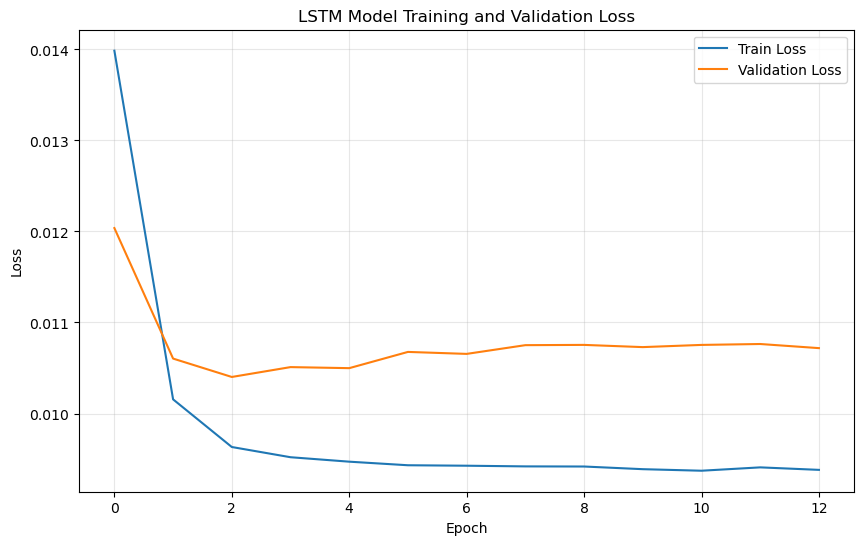

Test Loss: 0.0067
Test MSE: 0.2775
Test MAE: 0.3734
Test RMSE: 0.527


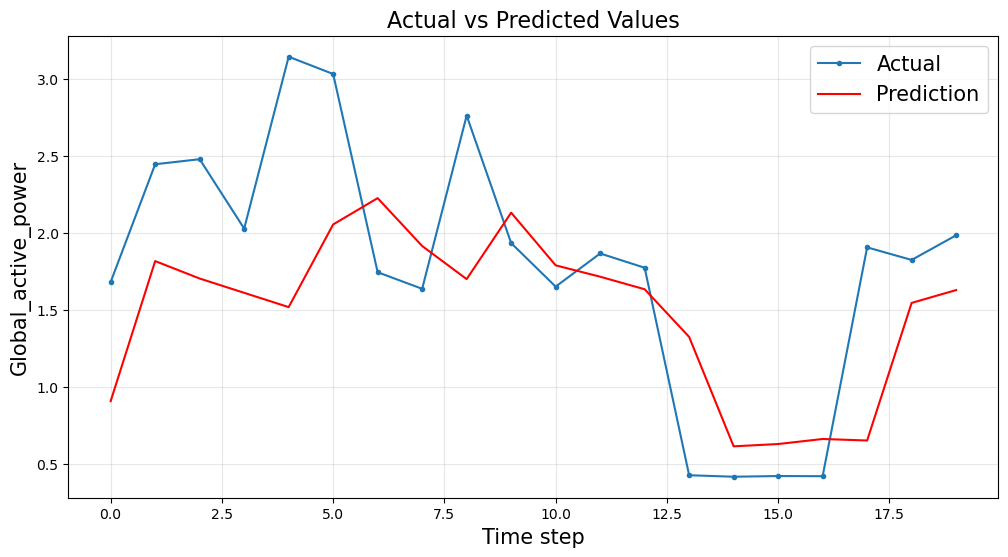

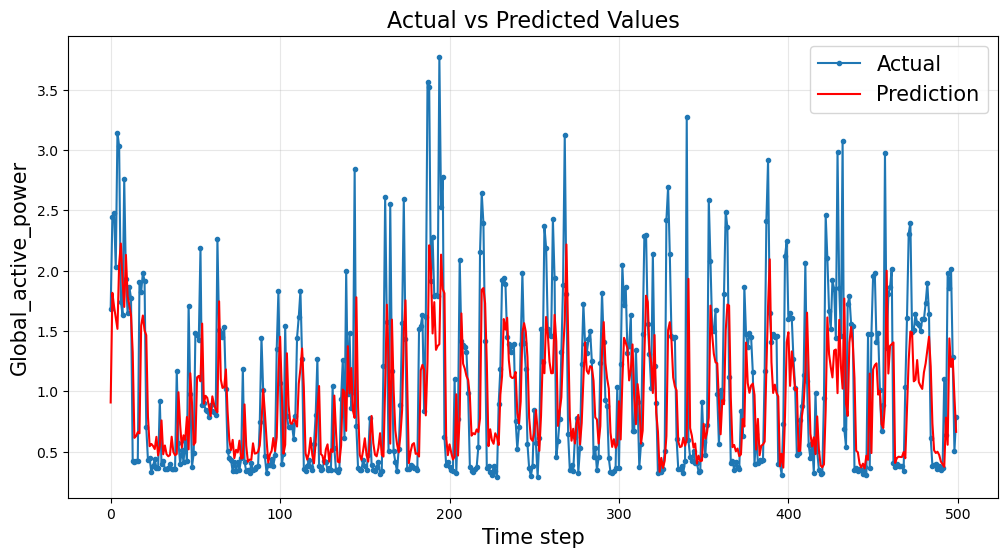

In [ ]:
## lstm early stopping learning rate schedule

from TimeSeriesLSTM import TimeSeriesLSTM

lstm_model = TimeSeriesLSTM(
    feature_dim=train_features_tensor.shape[2], 
    hidden_dim=100, 
    output_dim=1
)

loss_function = nn.MSELoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

early_stop_patience = 10
lowest_val_loss = float('inf')
stagnation_counter = 0

max_epochs = 50
training_history = []
validation_history = []

for epoch_idx in range(max_epochs):
    lstm_model.train()
    epoch_train_loss = 0
    for batch_features, batch_labels in train_data_loader:
        optimizer.zero_grad()
        predictions = lstm_model(batch_features)
        batch_loss = loss_function(predictions, batch_labels)
        
        batch_loss.backward()
        optimizer.step()
        epoch_train_loss += batch_loss.item()
    
    epoch_train_loss /= len(train_data_loader)
    training_history.append(epoch_train_loss)

    lstm_model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for batch_features, batch_labels in val_data_loader:
            predictions = lstm_model(batch_features)
            batch_loss = loss_function(predictions, batch_labels)
            epoch_val_loss += batch_loss.item()
        
        epoch_val_loss /= len(val_data_loader)
        validation_history.append(epoch_val_loss)

    current_lr = lr_scheduler.get_last_lr()[0]
    print(f"Epoch {epoch_idx+1}/{max_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, LR: {current_lr:.6f}")
    
    # lr_scheduler.step()

    if epoch_val_loss < lowest_val_loss:
        lowest_val_loss = epoch_val_loss
        stagnation_counter = 0
    else:
        stagnation_counter += 1
        if stagnation_counter >= early_stop_patience:
            print(f"Early stopping triggered after {epoch_idx+1} epochs.")
            break

plt.figure(figsize=(10, 6))
plt.plot(training_history, label='Train Loss')
plt.plot(validation_history, label='Validation Loss')
plt.title('LSTM Model Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.show()

lstm_model.eval()
with torch.no_grad():
    test_predictions = lstm_model(test_features_tensor)
    test_error = loss_function(test_predictions, test_labels_tensor).item()
    print(f"Test Loss: {test_error:.4f}")
    
    predicted_values = test_predictions.numpy()

denorm_predictions = np.concatenate((
    predicted_values,
    test_features_tensor.numpy()[:, 0, -6:]
), axis=1)
denorm_predictions = normalizer.inverse_transform(denorm_predictions)
final_predictions = denorm_predictions[:, 0]

denorm_actual = np.concatenate((
    test_labels_tensor.numpy(),
    test_features_tensor.numpy()[:, 0, -6:]
), axis=1)
denorm_actual = normalizer.inverse_transform(denorm_actual)
final_actual = denorm_actual[:, 0]

error_mse = mean_squared_error(final_actual, final_predictions)
error_mae = mean_absolute_error(final_actual, final_predictions)
error_rmse = np.sqrt(error_mse)

print(f'Test MSE: {error_mse:.4f}')
print(f'Test MAE: {error_mae:.4f}')
print(f'Test RMSE: {error_rmse:.3f}')

display_count = 20
time_indices = list(range(display_count))

plt.figure(figsize=(12, 6))
plt.plot(time_indices, final_actual[:display_count], marker='.', label="Actual")
plt.plot(time_indices, final_predictions[:display_count], 'r', label="Prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.title('Actual vs Predicted Values', size=16)
plt.legend(fontsize=15)
plt.grid(True, alpha=0.3)
plt.show()

display_count = 500
time_indices = list(range(display_count))

plt.figure(figsize=(12, 6))
plt.plot(time_indices, final_actual[:display_count], marker='.', label="Actual")
plt.plot(time_indices, final_predictions[:display_count], 'r', label="Prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.title('Actual vs Predicted Values', size=16)
plt.legend(fontsize=15)
plt.grid(True, alpha=0.3)
plt.show()



Epoch 1/50, Train Loss: 0.0135, Val Loss: 0.0115, LR: 0.001000
Epoch 2/50, Train Loss: 0.0099, Val Loss: 0.0104, LR: 0.001000
Epoch 3/50, Train Loss: 0.0096, Val Loss: 0.0104, LR: 0.001000
Epoch 4/50, Train Loss: 0.0095, Val Loss: 0.0104, LR: 0.001000
Epoch 5/50, Train Loss: 0.0094, Val Loss: 0.0105, LR: 0.001000
Epoch 6/50, Train Loss: 0.0094, Val Loss: 0.0106, LR: 0.001000
Epoch 7/50, Train Loss: 0.0094, Val Loss: 0.0107, LR: 0.001000
Epoch 8/50, Train Loss: 0.0094, Val Loss: 0.0107, LR: 0.001000
Epoch 9/50, Train Loss: 0.0094, Val Loss: 0.0107, LR: 0.001000
Epoch 10/50, Train Loss: 0.0094, Val Loss: 0.0107, LR: 0.001000
Epoch 11/50, Train Loss: 0.0094, Val Loss: 0.0111, LR: 0.000500
Epoch 12/50, Train Loss: 0.0093, Val Loss: 0.0110, LR: 0.000500
Epoch 13/50, Train Loss: 0.0093, Val Loss: 0.0109, LR: 0.000500
Early stopping triggered after 13 epochs.


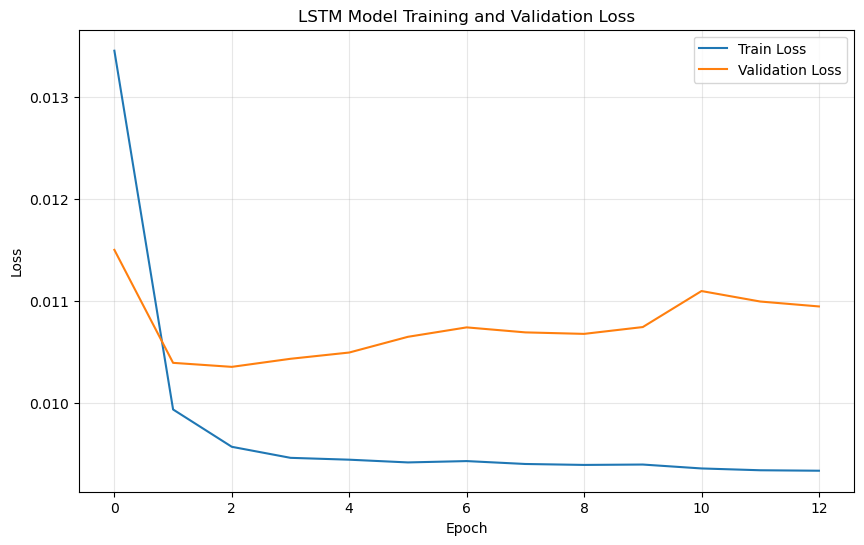

Test Loss: 0.0068
Test MSE: 0.2831
Test MAE: 0.3654
Test RMSE: 0.532


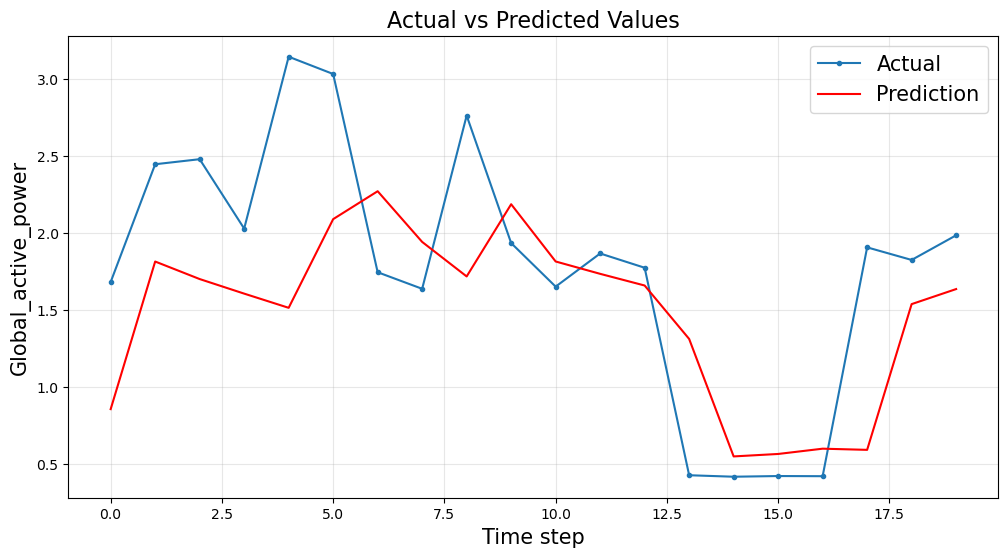

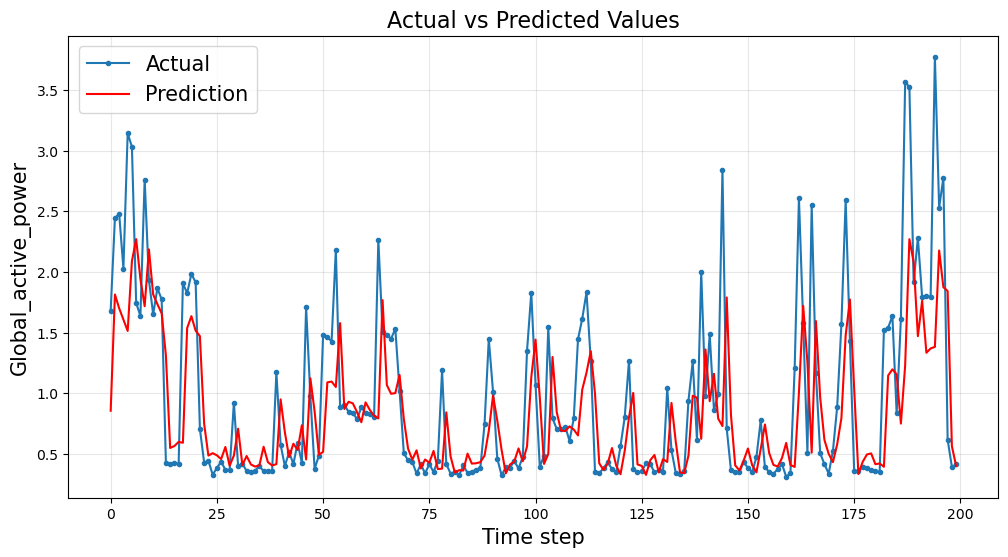

In [ ]:
## lstm early stopping learning rate schedule

from TimeSeriesLSTM import TimeSeriesLSTM

lstm_model = TimeSeriesLSTM(
    feature_dim=train_features_tensor.shape[2], 
    hidden_dim=100, 
    output_dim=1
)

loss_function = nn.MSELoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

early_stop_patience = 10
lowest_val_loss = float('inf')
stagnation_counter = 0

max_epochs = 50
training_history = []
validation_history = []

for epoch_idx in range(max_epochs):
    lstm_model.train()
    epoch_train_loss = 0
    for batch_features, batch_labels in train_data_loader:
        optimizer.zero_grad()
        predictions = lstm_model(batch_features)
        batch_loss = loss_function(predictions, batch_labels)
        
        batch_loss.backward()
        optimizer.step()
        epoch_train_loss += batch_loss.item()
    
    epoch_train_loss /= len(train_data_loader)
    training_history.append(epoch_train_loss)

    lstm_model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for batch_features, batch_labels in val_data_loader:
            predictions = lstm_model(batch_features)
            batch_loss = loss_function(predictions, batch_labels)
            epoch_val_loss += batch_loss.item()
        
        epoch_val_loss /= len(val_data_loader)
        validation_history.append(epoch_val_loss)

    current_lr = lr_scheduler.get_last_lr()[0]
    print(f"Epoch {epoch_idx+1}/{max_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, LR: {current_lr:.6f}")
    
    lr_scheduler.step()

    if epoch_val_loss < lowest_val_loss:
        lowest_val_loss = epoch_val_loss
        stagnation_counter = 0
    else:
        stagnation_counter += 1
        if stagnation_counter >= early_stop_patience:
            print(f"Early stopping triggered after {epoch_idx+1} epochs.")
            break

plt.figure(figsize=(10, 6))
plt.plot(training_history, label='Train Loss')
plt.plot(validation_history, label='Validation Loss')
plt.title('LSTM Model Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.show()

lstm_model.eval()
with torch.no_grad():
    test_predictions = lstm_model(test_features_tensor)
    test_error = loss_function(test_predictions, test_labels_tensor).item()
    print(f"Test Loss: {test_error:.4f}")
    
    predicted_values = test_predictions.numpy()

denorm_predictions = np.concatenate((
    predicted_values,
    test_features_tensor.numpy()[:, 0, -6:]
), axis=1)
denorm_predictions = normalizer.inverse_transform(denorm_predictions)
final_predictions = denorm_predictions[:, 0]

denorm_actual = np.concatenate((
    test_labels_tensor.numpy(),
    test_features_tensor.numpy()[:, 0, -6:]
), axis=1)
denorm_actual = normalizer.inverse_transform(denorm_actual)
final_actual = denorm_actual[:, 0]

error_mse = mean_squared_error(final_actual, final_predictions)
error_mae = mean_absolute_error(final_actual, final_predictions)
error_rmse = np.sqrt(error_mse)


print(f'Test MSE: {error_mse:.4f}')
print(f'Test MAE: {error_mae:.4f}')
print(f'Test RMSE: {error_rmse:.3f}')

display_count = 20
time_indices = list(range(display_count))

plt.figure(figsize=(12, 6))
plt.plot(time_indices, final_actual[:display_count], marker='.', label="Actual")
plt.plot(time_indices, final_predictions[:display_count], 'r', label="Prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.title('Actual vs Predicted Values', size=16)
plt.legend(fontsize=15)
plt.grid(True, alpha=0.3)
plt.show()

display_count = 500
time_indices = list(range(display_count))

plt.figure(figsize=(12, 6))
plt.plot(time_indices, final_actual[:display_count], marker='.', label="Actual")
plt.plot(time_indices, final_predictions[:display_count], 'r', label="Prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.title('Actual vs Predicted Values', size=16)
plt.legend(fontsize=15)
plt.grid(True, alpha=0.3)
plt.show()
